# Contents

#### 1 Importing libraries/datasets
#### 2 Wrangling dataset
#### 3 Time-series analysis-decomposition
#### 4 Testing for stationarity
#### 5 Stationarizing data 
#### 6 Time-series forecasting

## 1 Importing libraries/datasets

In [1]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm 
import os
import warnings 

warnings.filterwarnings("ignore") 

plt.style.use('fivethirtyeight') 

In [2]:
#importing delays time series (2014-2021)
path=r'/Users/Amaikuru/Desktop/Toronto Bus Delays'
#importing data
df=pd.read_pickle(os.path.join(path, '02 Data','Prepared', 'delay_series.pkl'))

 ## 2 Wrangling dataset

In [3]:
#data already cleaned
df.dtypes

Date           datetime64[ns]
delay_count           float64
dtype: object

In [4]:
#making date index
df = df.set_index('Date')

In [5]:
df.head()

delay_count
Date                   
2014-01-01        125.0
2014-01-02        463.0
2014-01-03        525.0
2014-01-04        225.0
2014-01-05         97.0

In [6]:
df.isnull().sum()

delay_count    4
dtype: int64

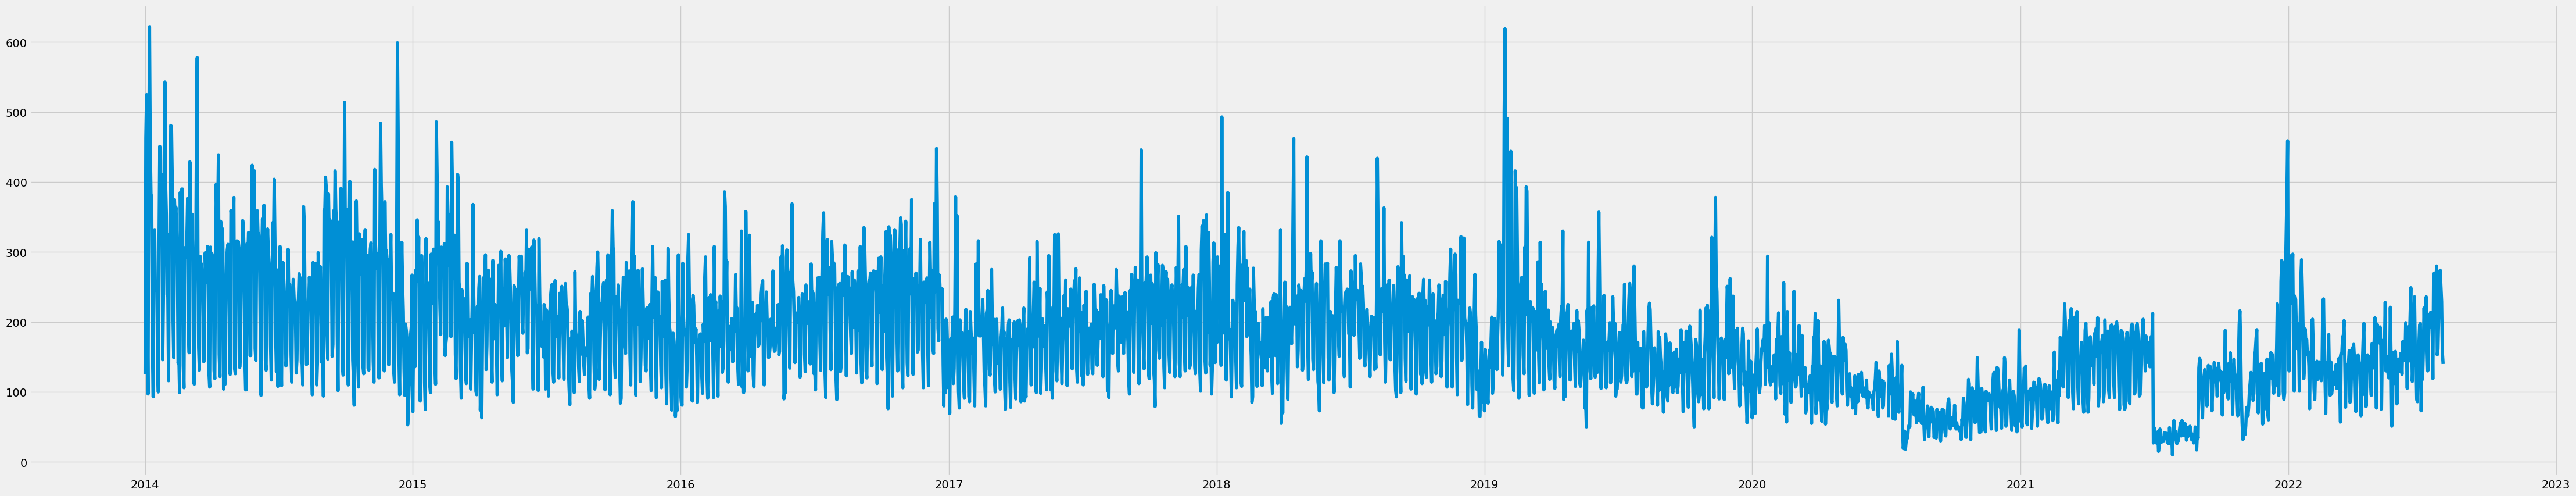

In [7]:
# Plot the data using matplotlib
plt.figure(figsize=(50,10), dpi=100) 

plt.plot(df)


In [8]:
## there is no data for the 1st to 4th of july 2020, will be interpolating with values nearer to the time
df['delay_count']=df['delay_count'].interpolate(option='time')

In [9]:
df.isnull().sum()

delay_count    0
dtype: int64

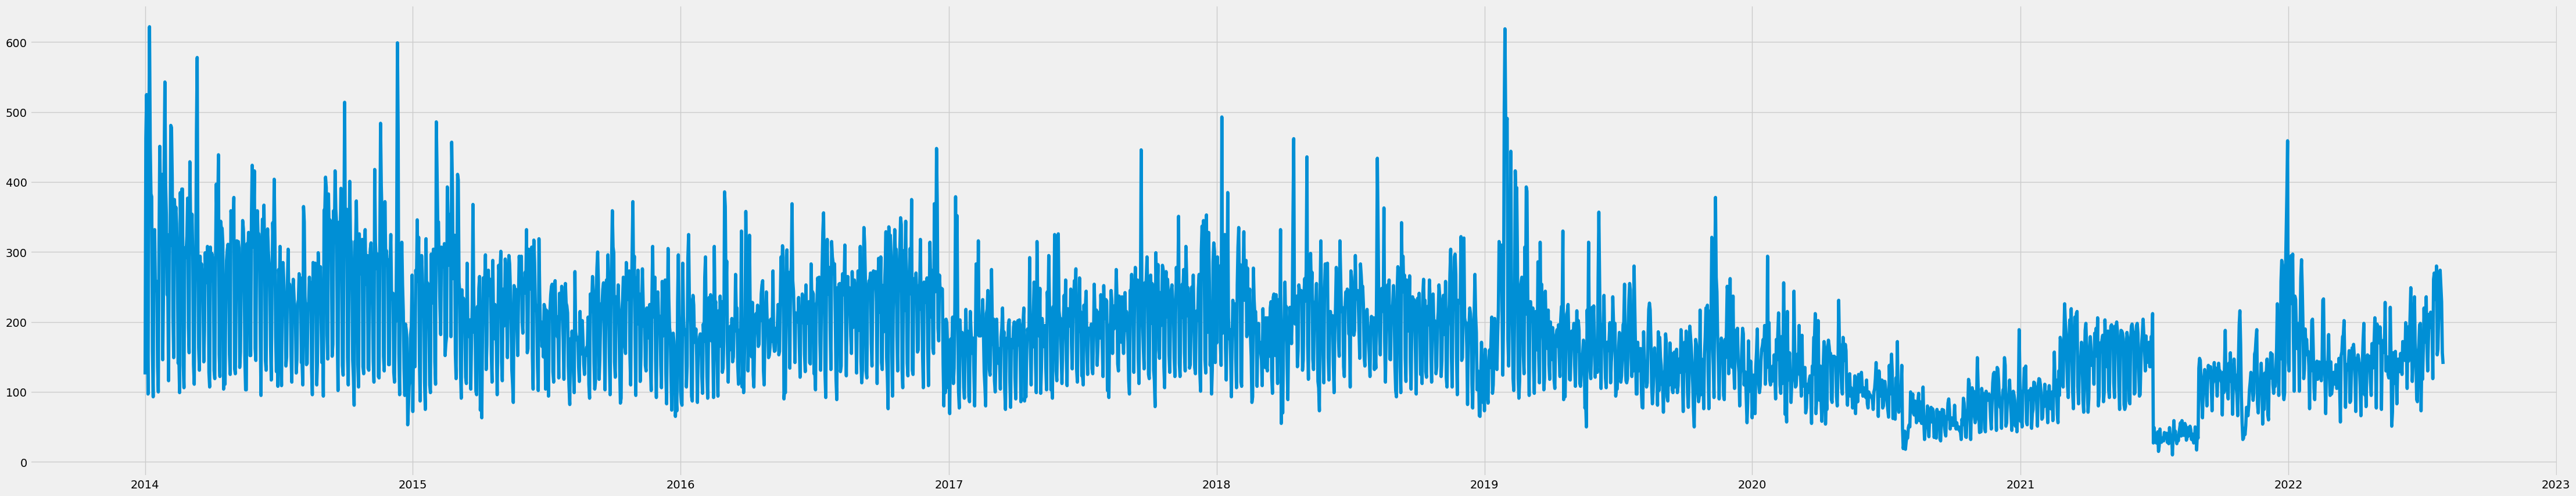

In [10]:
# Plot the data using matplotlib
plt.figure(figsize=(50,10), dpi=100) 

plt.plot(df)


In [14]:
df_in=df.reset_index()

#### there is no clear trend or seasonality here

## 3 Time-series analysis: decomposition

In [15]:
#because there are so many data points and I see no clear trends or seasonality, I will be smoothing the time series 
#using gaussian smoothing
smoothed_count = []
for date in sorted(df_in['Date']):
    df_in['gkv'] = np.exp( -(((df_in['Date'] - date).apply(lambda x: x.days)) ** 2) / (2 * (4 ** 2)) #b set to 4 for higher smoothing
    )
    df_in['gkv'] /= df_in['gkv'].sum()
    smoothed_count.append(round(df_in['delay_count'] * df_in['gkv']).sum())

df_in['smoothed_count'] = smoothed_count

In [16]:
df['delay_smooth'] = smoothed_count

In [17]:
df.head()

delay_count  delay_smooth
Date                                 
2014-01-01        125.0         336.0
2014-01-02        463.0         342.0
2014-01-03        525.0         346.0
2014-01-04        225.0         352.0
2014-01-05         97.0         352.0

In [18]:
#creating subset with only smooth values
df2=df[['delay_smooth']]

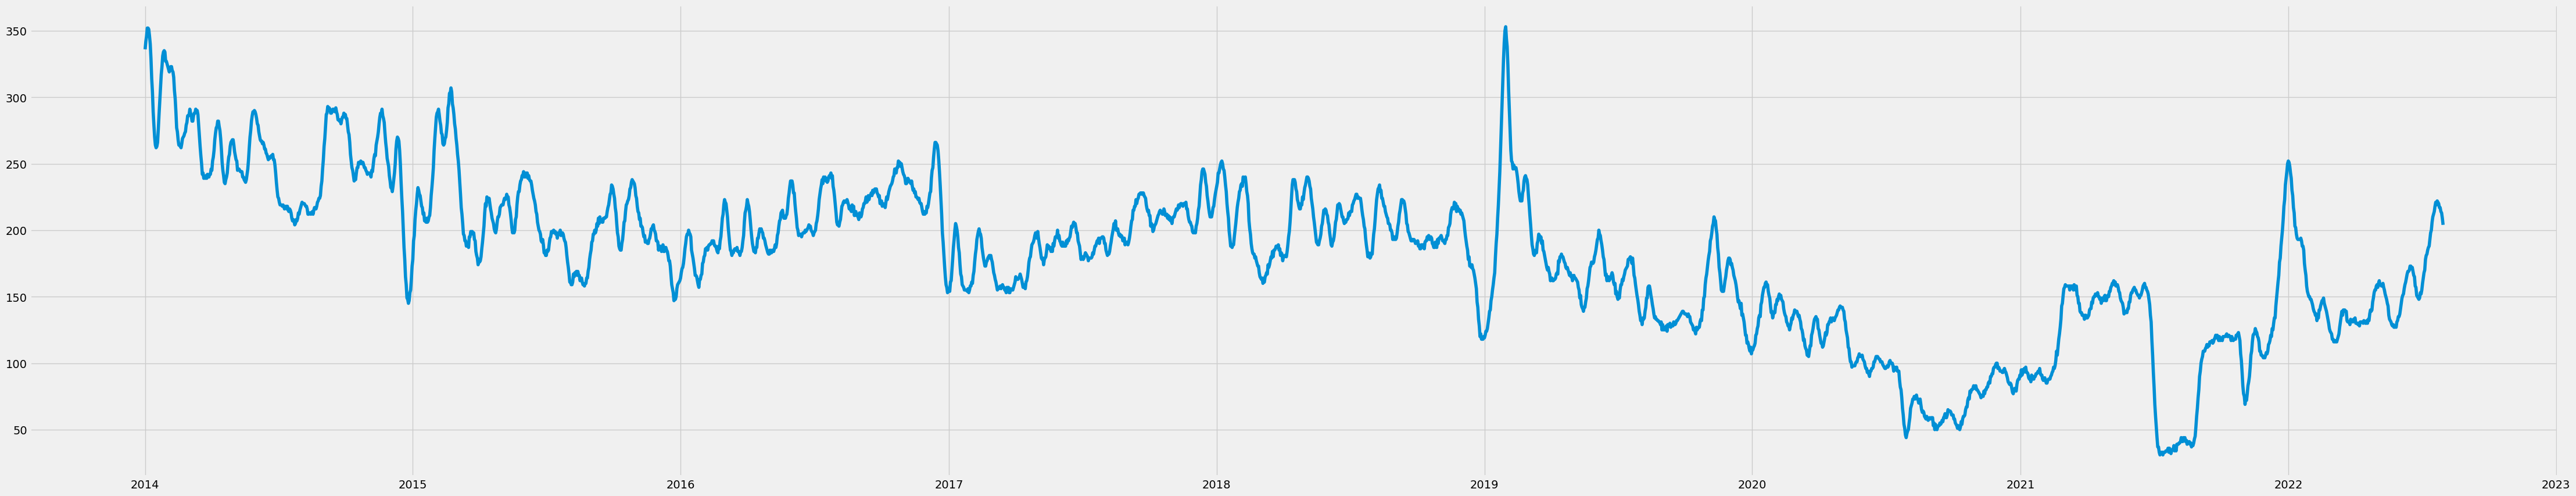

In [19]:
#plotting smooth data
plt.figure(figsize=(50,10), dpi=100) 

plt.plot(df2)

#### It is easier to see trends now

In [20]:
# Decomposing the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(df2, model='additive')

In [21]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 70,36

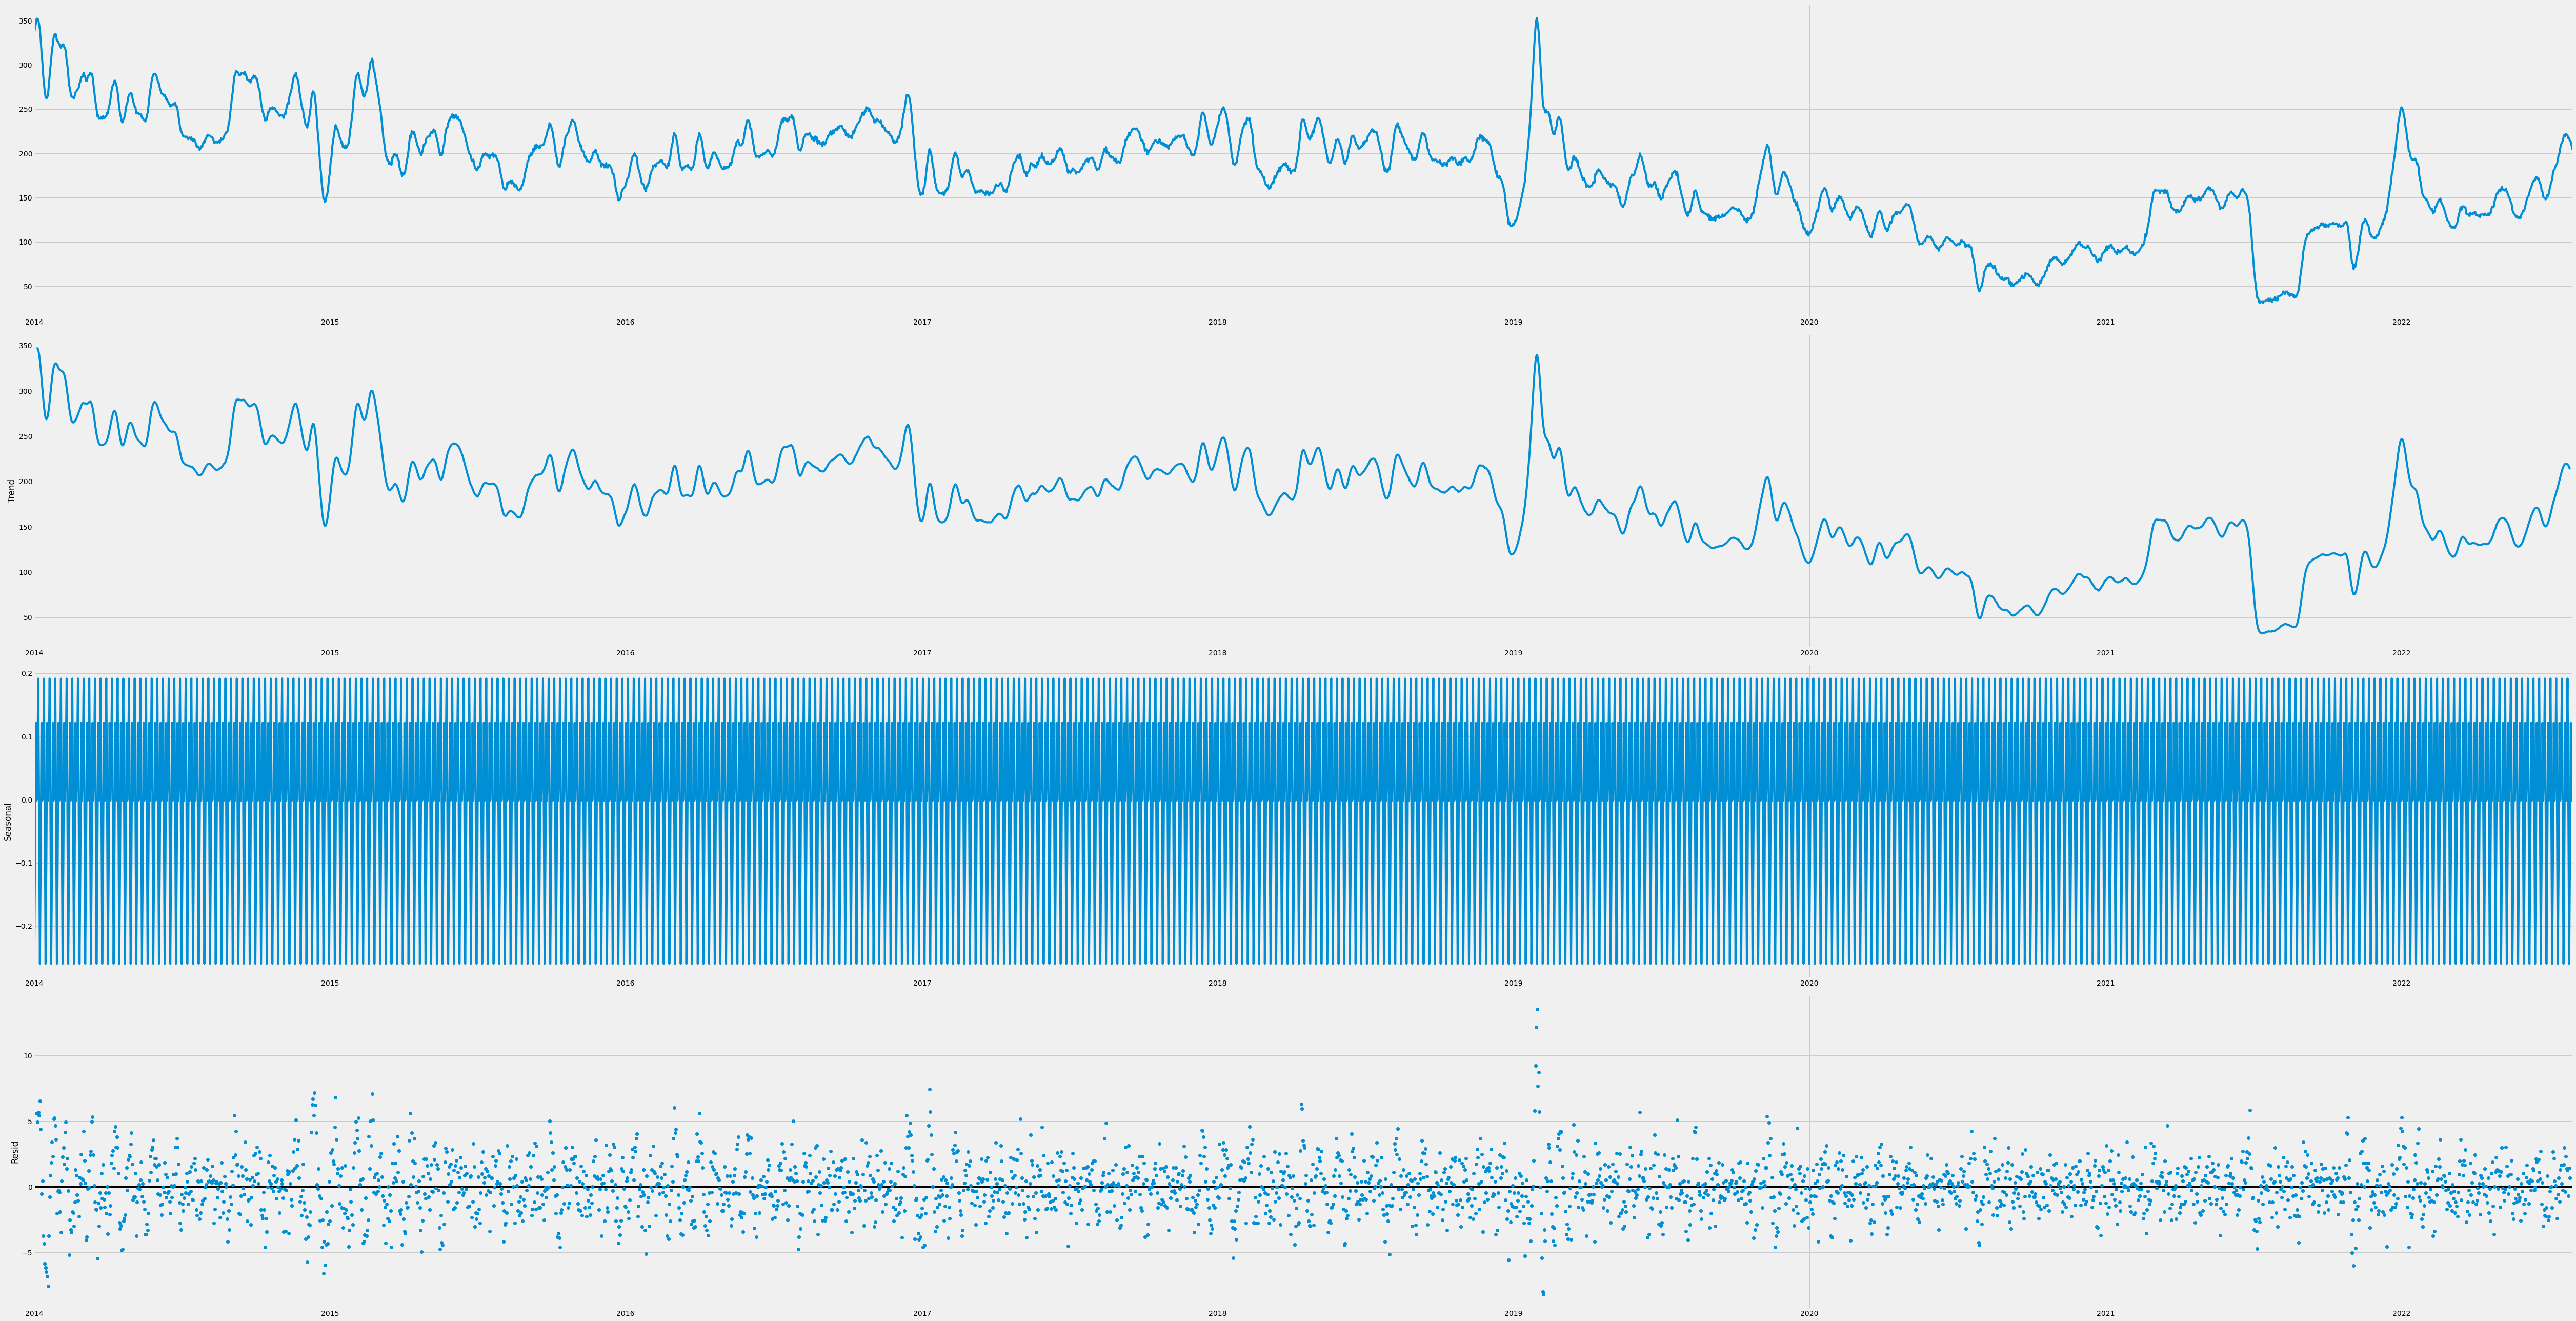

In [22]:
# Plot the separate components

decomposition.plot()
plt.show()

#### the data seems to be non stationary with a  general downward trend, but after a dip in 2021 it seems to be trending up again, there is a lot of noise but less than before, there seems to be seasonailty but  cannot see this properly

## 4 Testing for stationarity

#### Null hypothesis: There is a unit root in the data (the time series in non-stationary)

In [23]:

from statsmodels.tsa.stattools import adfuller 

def dickey_fuller(timeseries): 

    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(df2['delay_smooth'])

Dickey-Fuller Stationarity test:
Test Statistic                   -3.884707
p-value                           0.002150
Number of Lags Used              25.000000
Number of Observations Used    3108.000000
Critical Value (1%)              -3.432456
Critical Value (5%)              -2.862470
Critical Value (10%)             -2.567265
dtype: float64


#### As it turns out, the null hypothesis can be rejected, the Test statistic is smaller than the critical value at 5% and the p-value is much less than 0.05 showing that the result is significant. The test shows that the time series is stationary

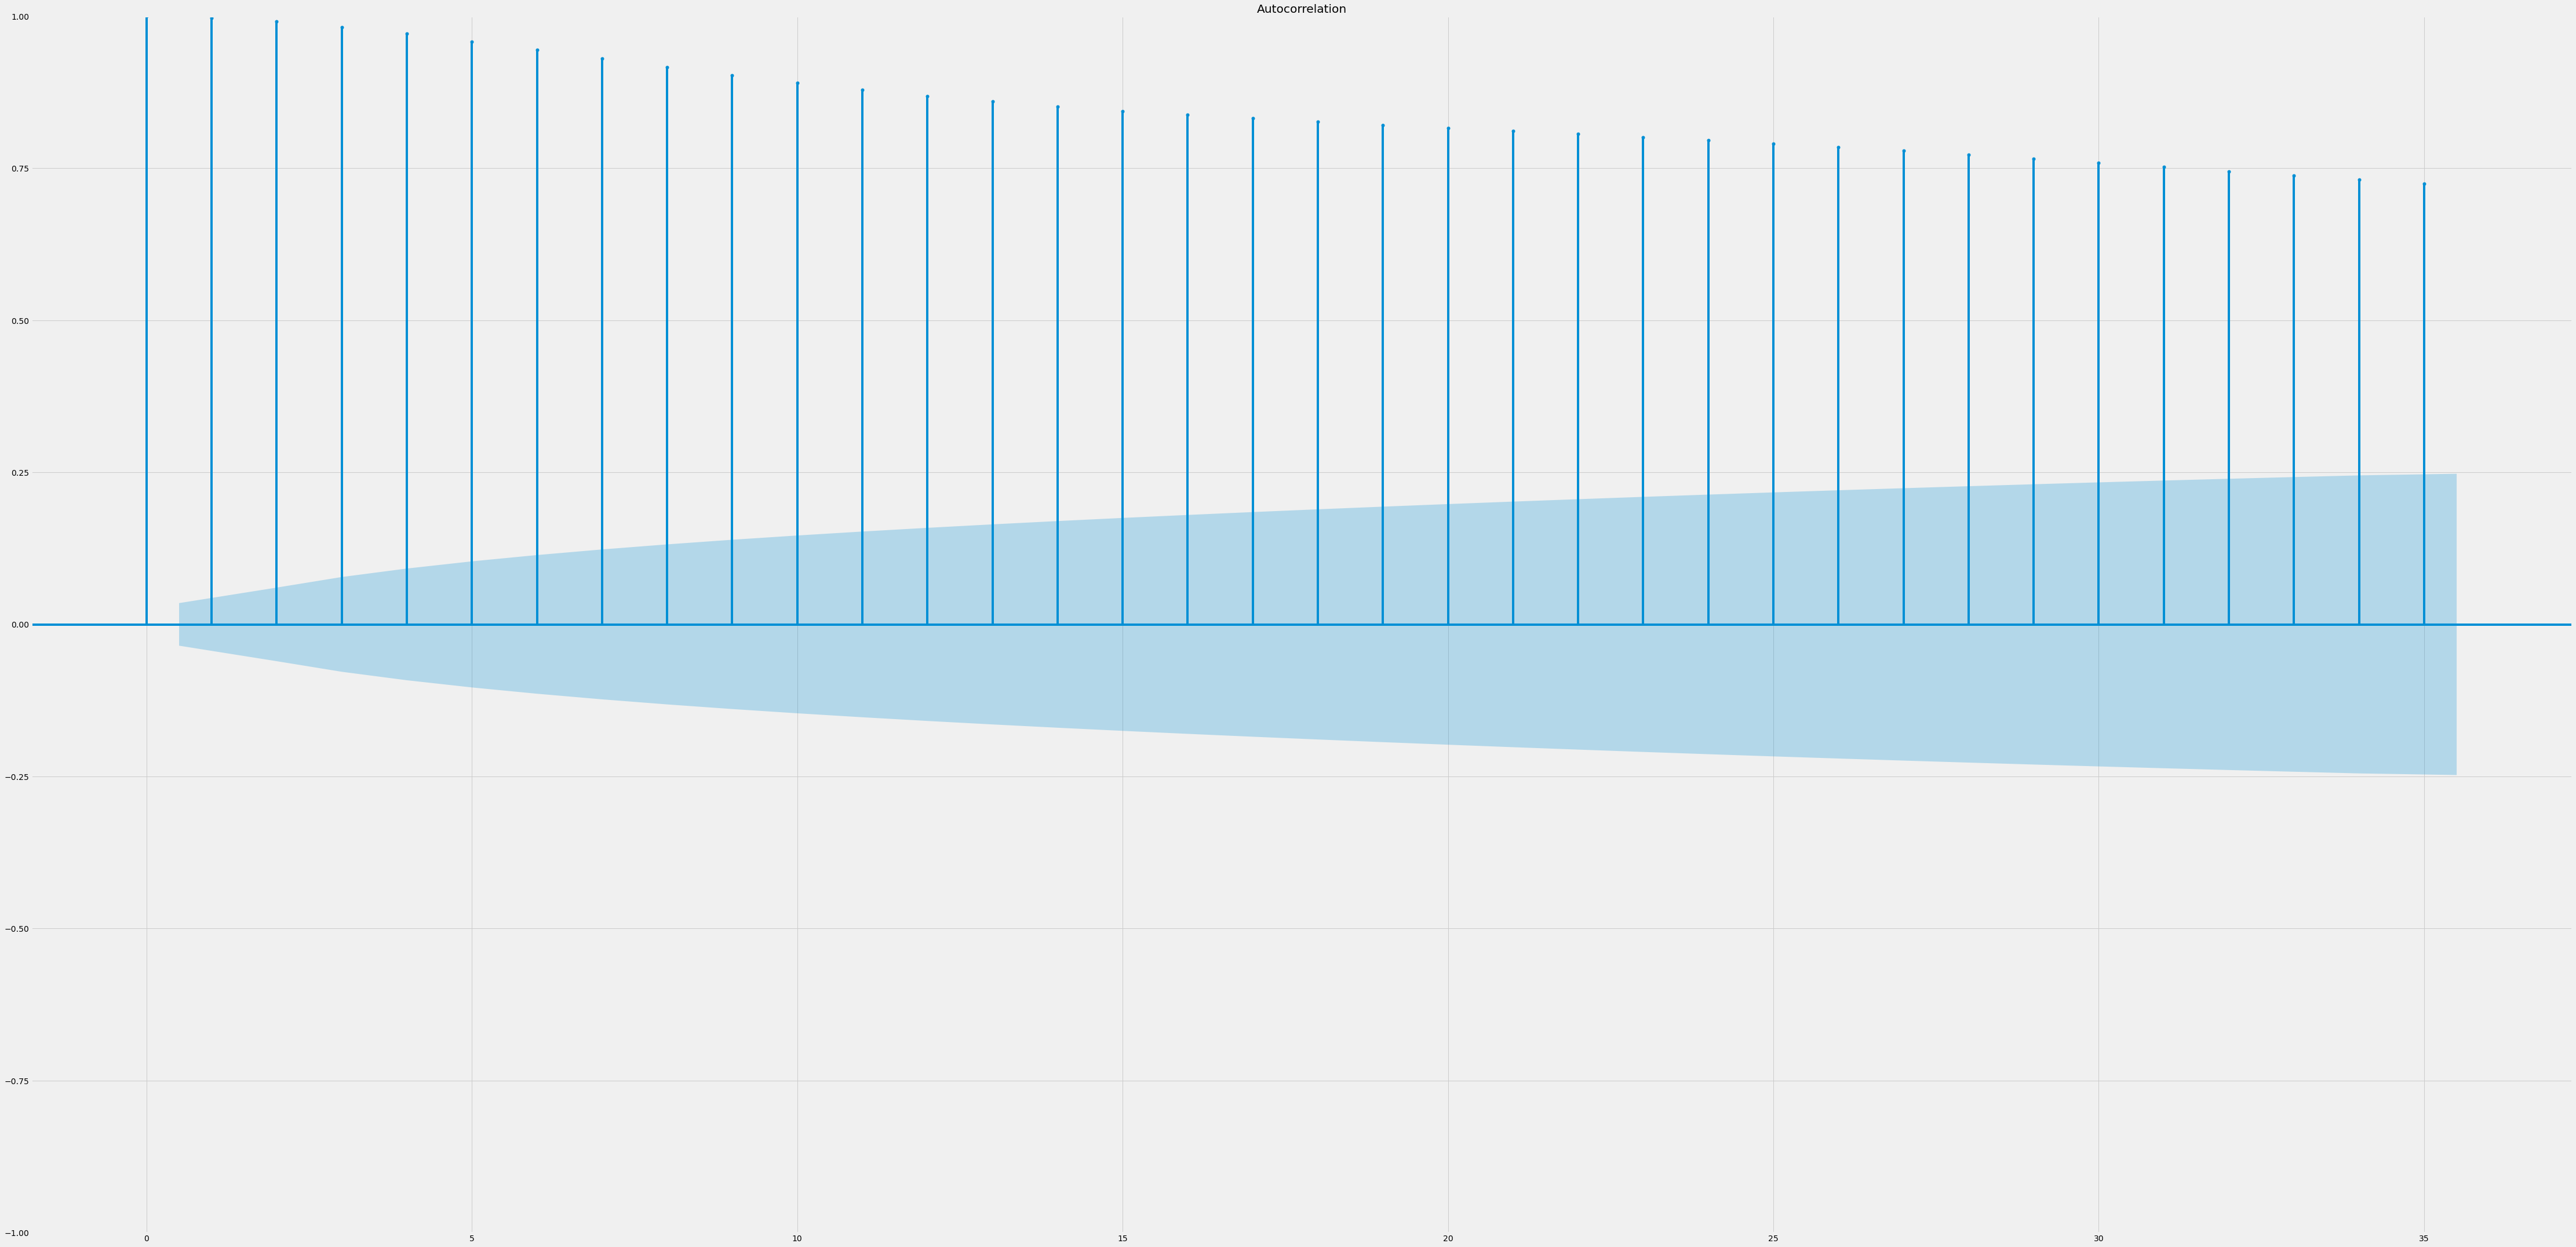

In [24]:
#checking data auto-correlation
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(df2)
plt.show()

#### Because there are more than ten significan lags, I will be differencing the time series to improve stationarity

## 5 Stationarizing data

In [25]:
#finding delta for each time shift
data_diff = df2 - df2.shift(1)

In [26]:
#removing missing values
data_diff.dropna(inplace = True) 

In [27]:
data_diff.head()

delay_smooth
Date                    
2014-01-02           6.0
2014-01-03           4.0
2014-01-04           6.0
2014-01-05           0.0
2014-01-06          -1.0

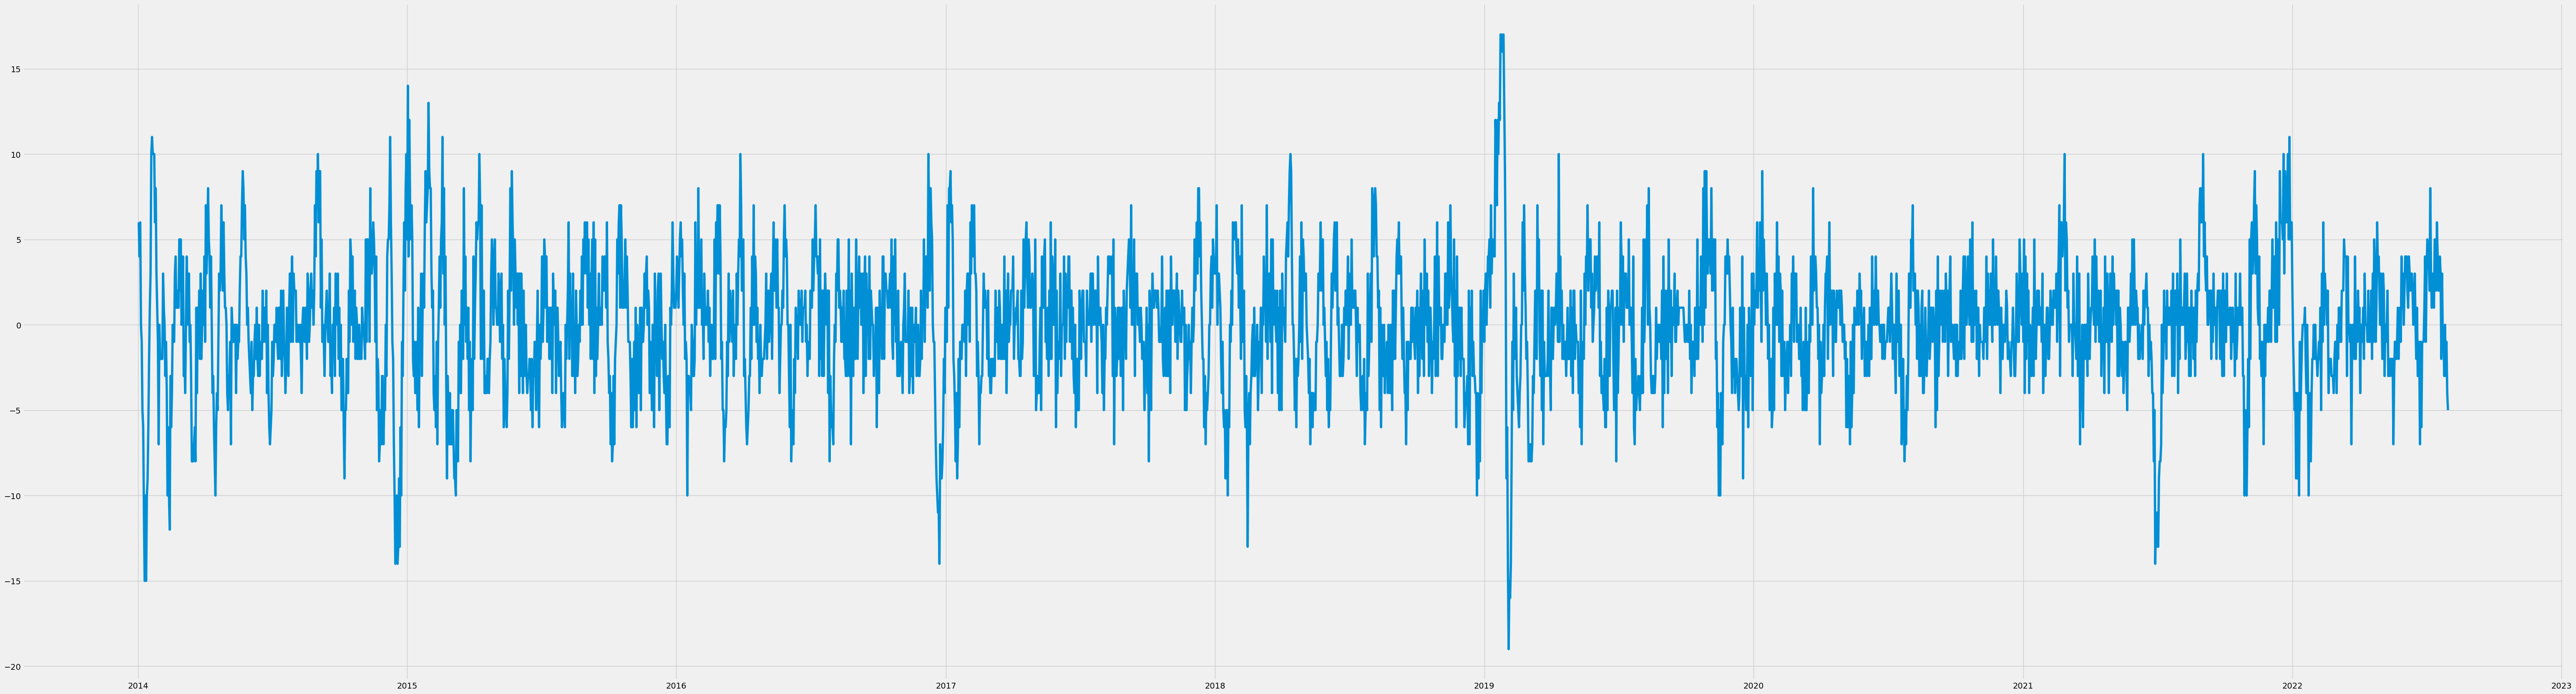

In [28]:
plt.figure(figsize=(70,20), dpi=100)
plt.plot(data_diff)

#### the differencing seems to have improved the stationarity of the time series

In [29]:
#conducting another dicky fuller test
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                -1.122584e+01
p-value                        1.961599e-20
Number of Lags Used            2.900000e+01
Number of Observations Used    3.103000e+03
Critical Value (1%)           -3.432459e+00
Critical Value (5%)           -2.862472e+00
Critical Value (10%)          -2.567266e+00
dtype: float64


#### The test statistic is much smaller than the critical value and the p value is significant so once again, the null hypothesis can be rejected and the test shows the time series is stationary

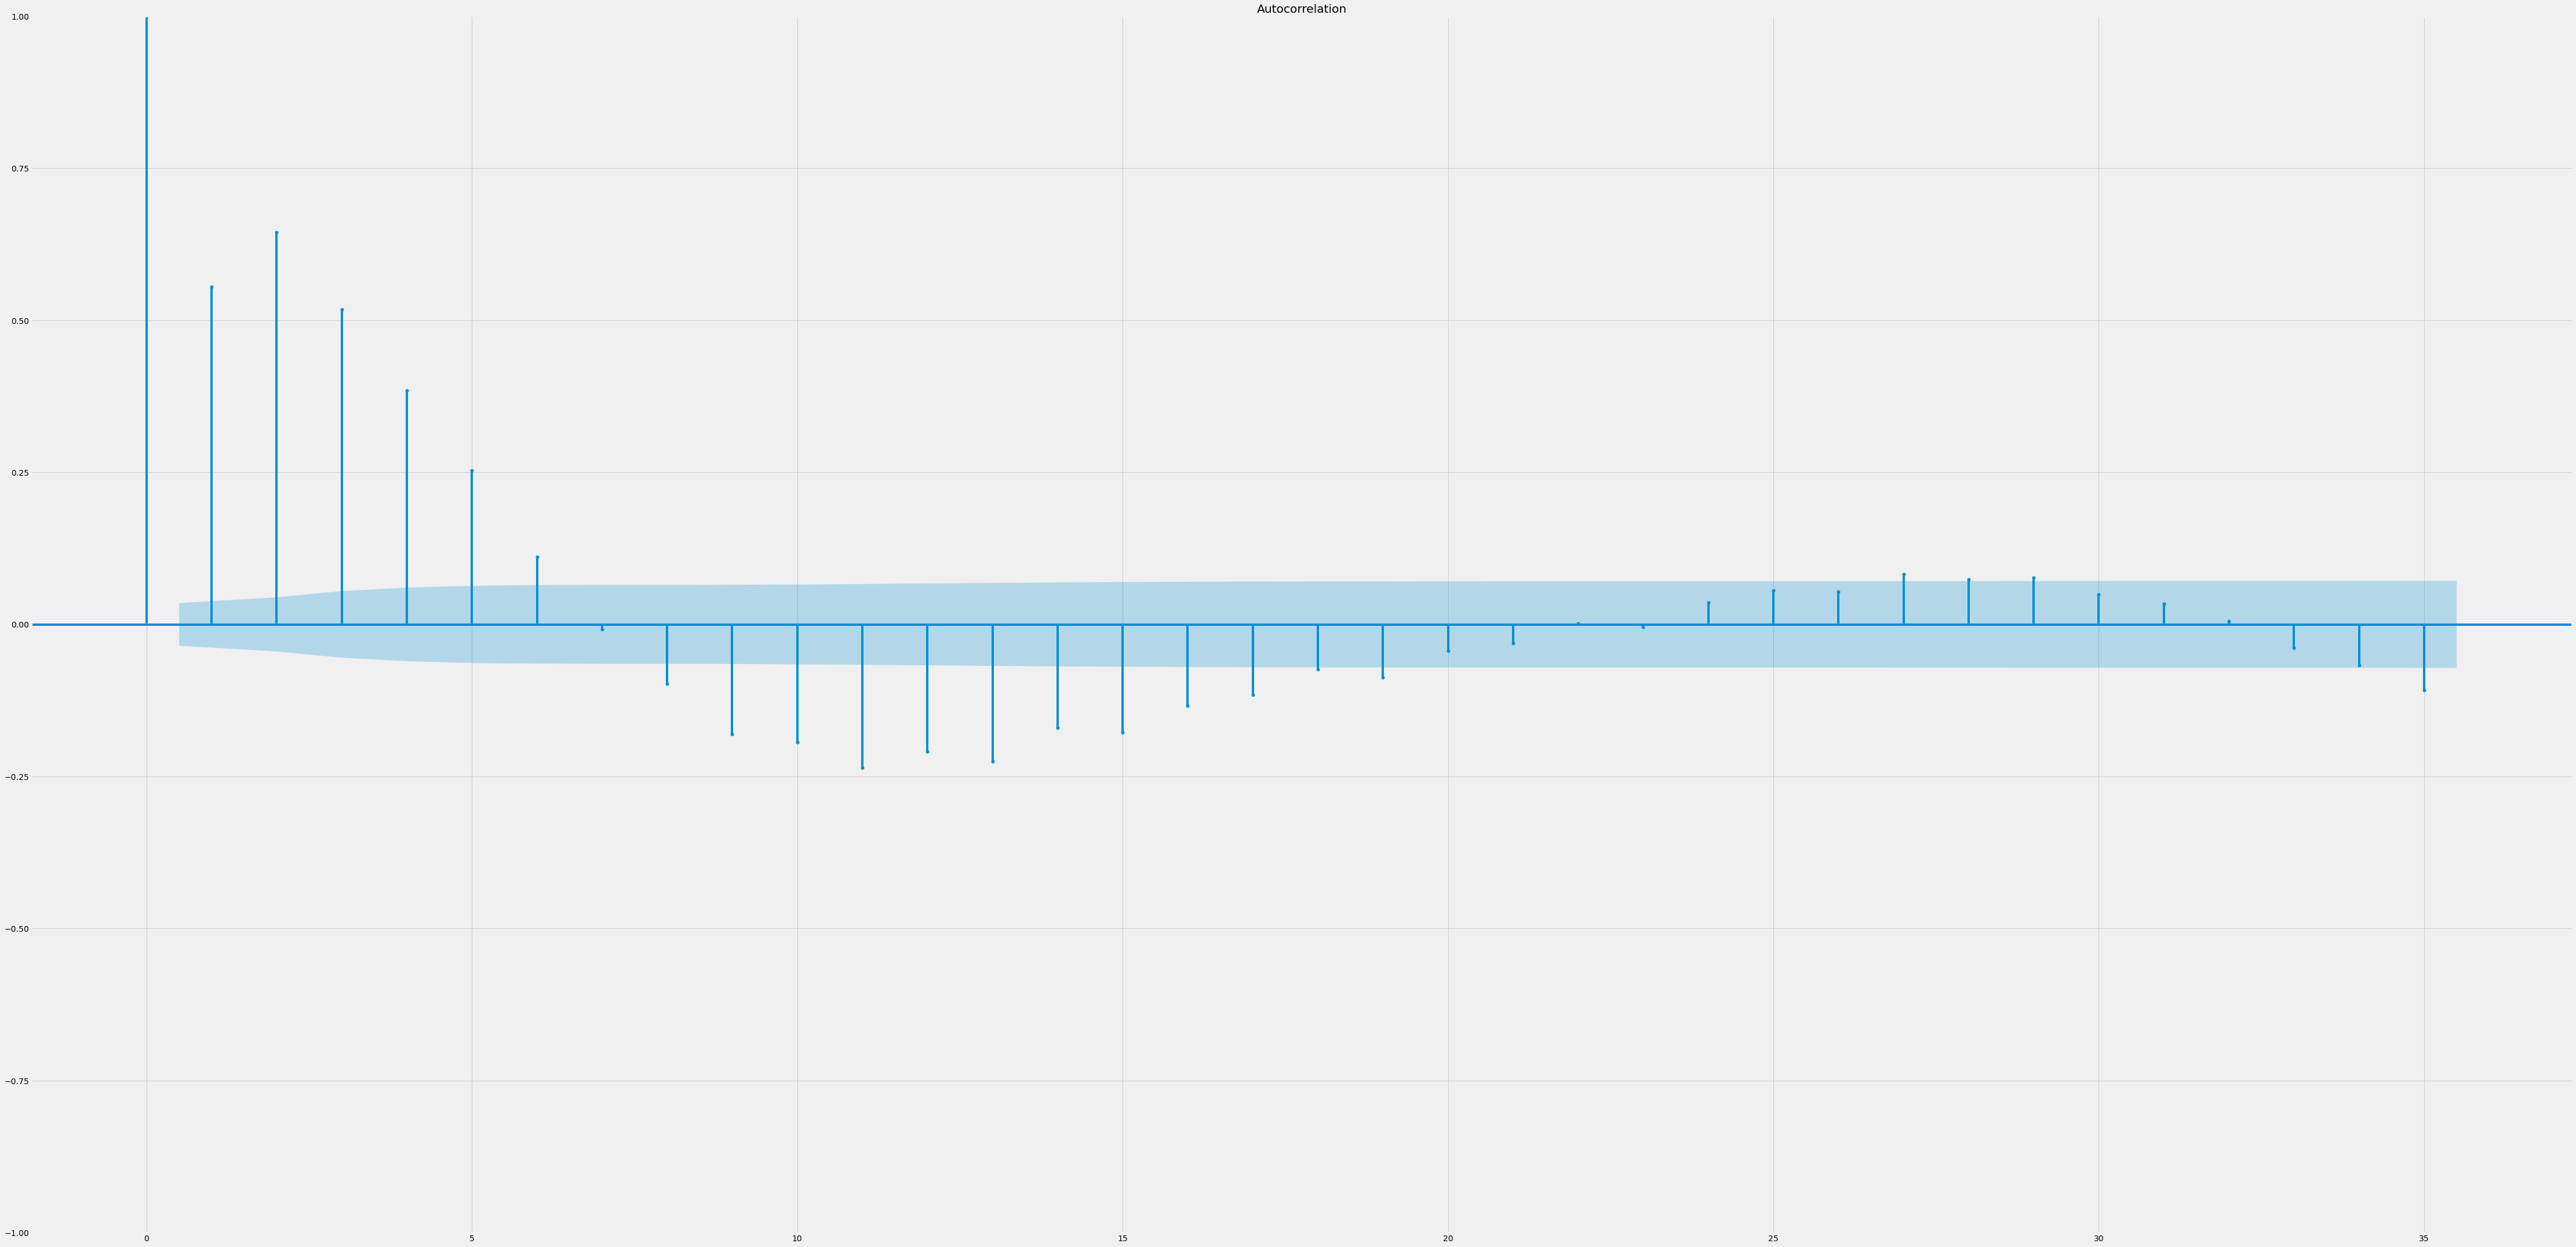

In [30]:
#checking for autocorrelation
plot_acf(data_diff)
plt.show()

#### once again, there are over 10 significant lags meaning the stationarity is week so i will be performing another round of differencing

In [31]:
#finding delta for each time shift
data_diff2 = data_diff - data_diff.shift(1)

In [32]:
#removing missing values
data_diff2.dropna(inplace = True) 

In [33]:
data_diff2.head()

delay_smooth
Date                    
2014-01-03          -2.0
2014-01-04           2.0
2014-01-05          -6.0
2014-01-06          -1.0
2014-01-07          -4.0

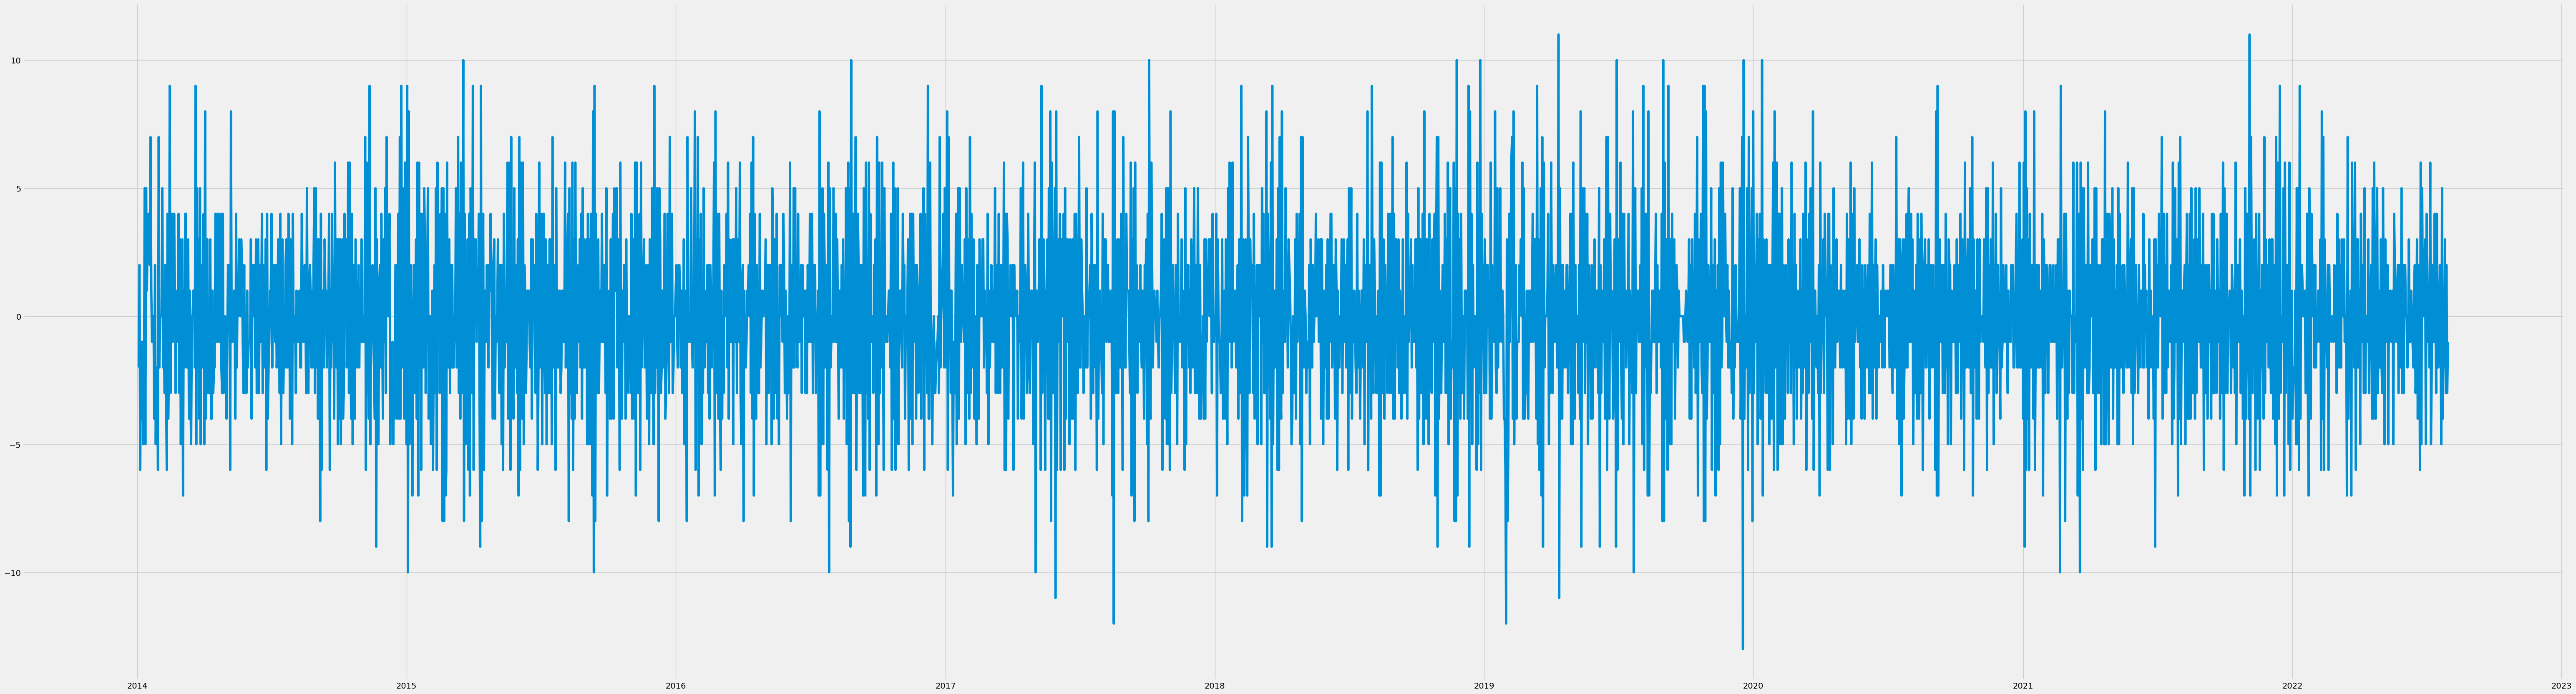

In [34]:
plt.figure(figsize=(70,20), dpi=100)
plt.plot(data_diff2)

#### the stationarity seems to have improved

In [35]:
#conducting another dicky fuller test
dickey_fuller(data_diff2)

Dickey-Fuller Stationarity test:
Test Statistic                  -19.388529
p-value                           0.000000
Number of Lags Used              25.000000
Number of Observations Used    3106.000000
Critical Value (1%)              -3.432457
Critical Value (5%)              -2.862471
Critical Value (10%)             -2.567266
dtype: float64


#### the Test statistic is smaller than the critical value so the null hypothesis can be rejected, the p value shows the result is significant

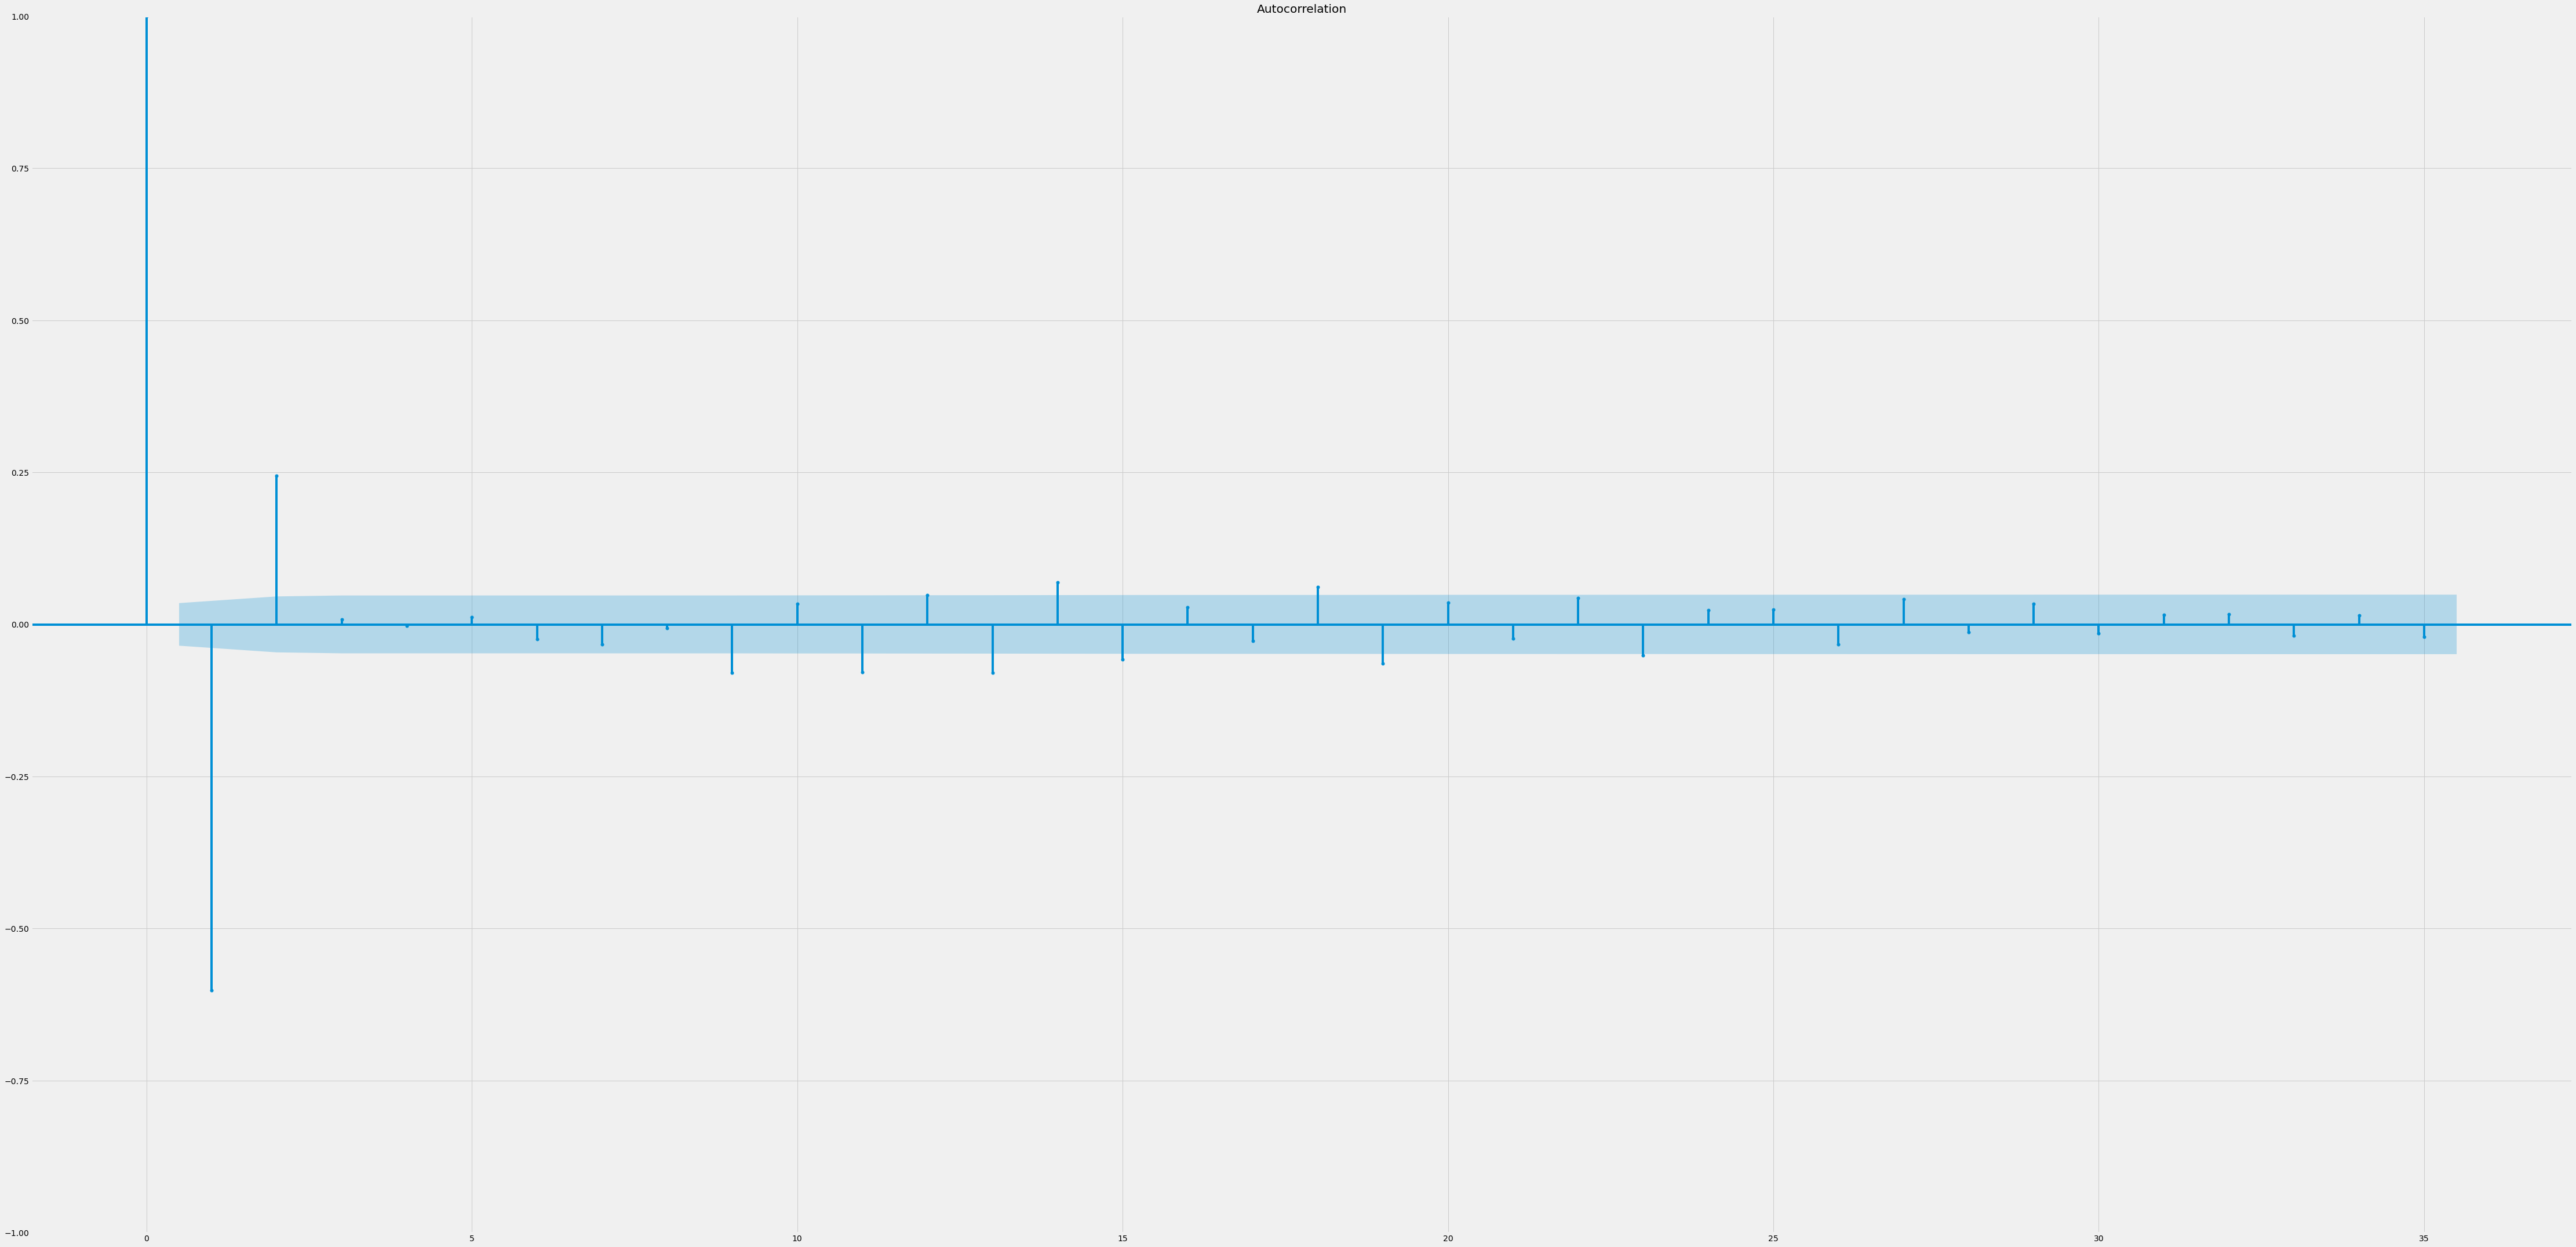

In [36]:
#checking for autocorrelation
plot_acf(data_diff2)
plt.show()

#### There are about 10 siginficant lags but to prevent loss of information, I will not be differencing this model a third time

## 6 Time-series Forecasting 

### a Defining parameters

In [37]:
df_new=data_diff2

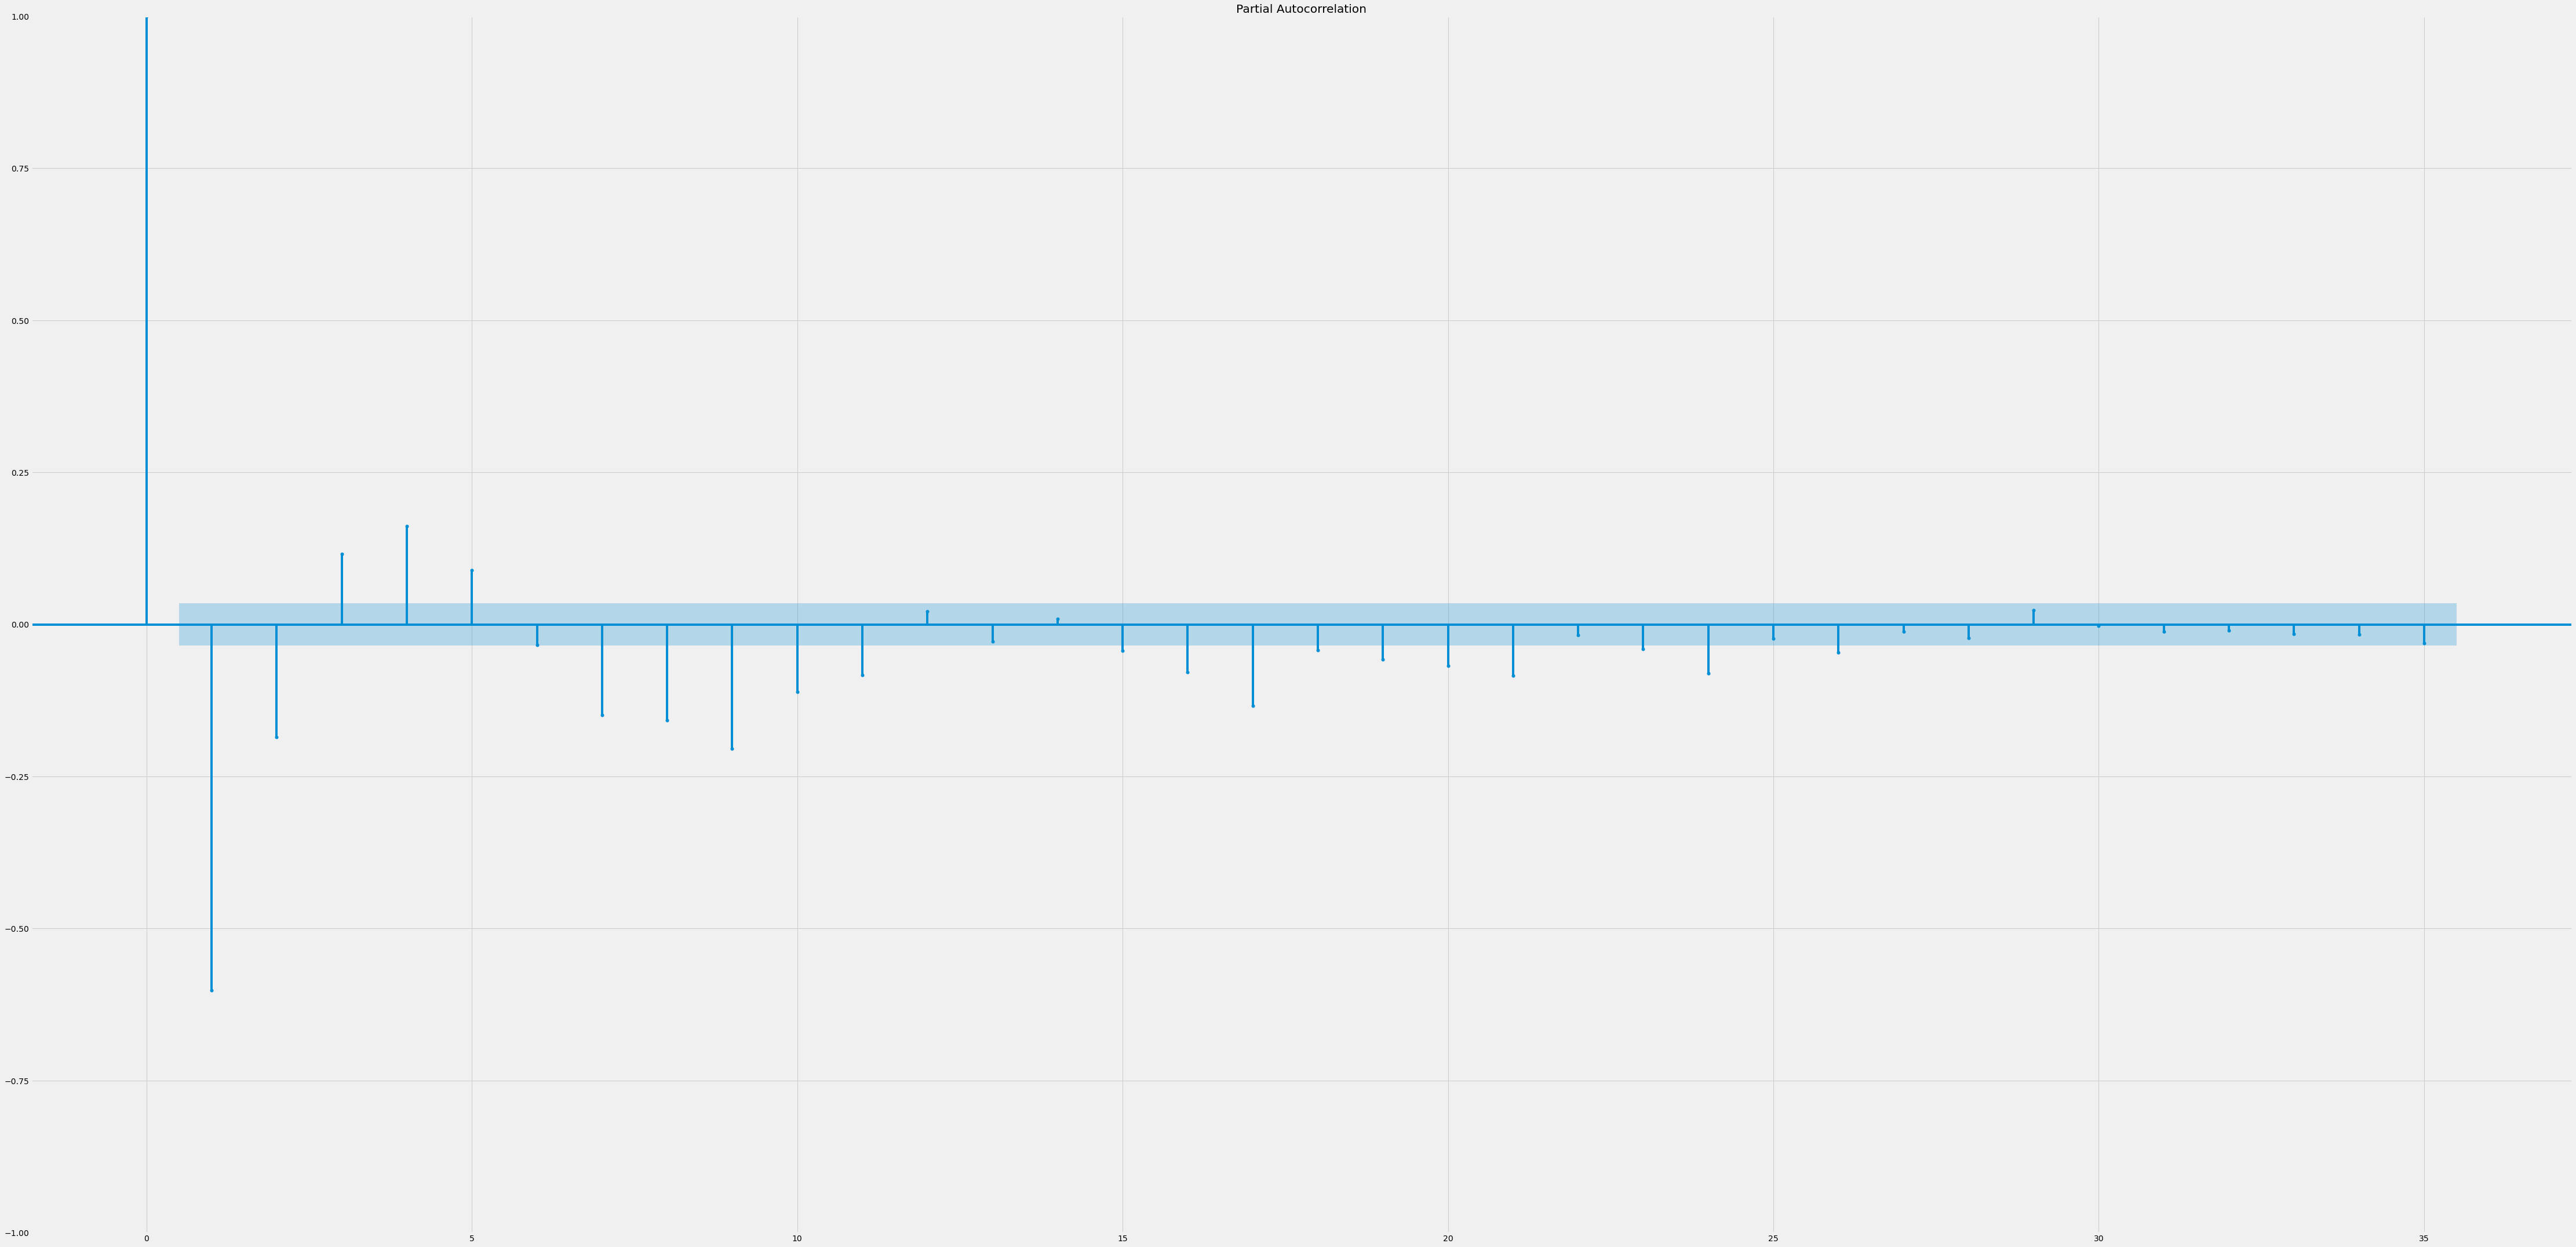

<Figure size 4500x4500 with 0 Axes>

In [38]:
# Plot partial autocorrelations to determine parameter p
#d=2
plot_pacf(df_new)
plt.figure(figsize=(15,15), dpi=300)
plt.show()

#### will be using a p-value of order 1 because the first lag is significantly out of the limit compared to the second lag

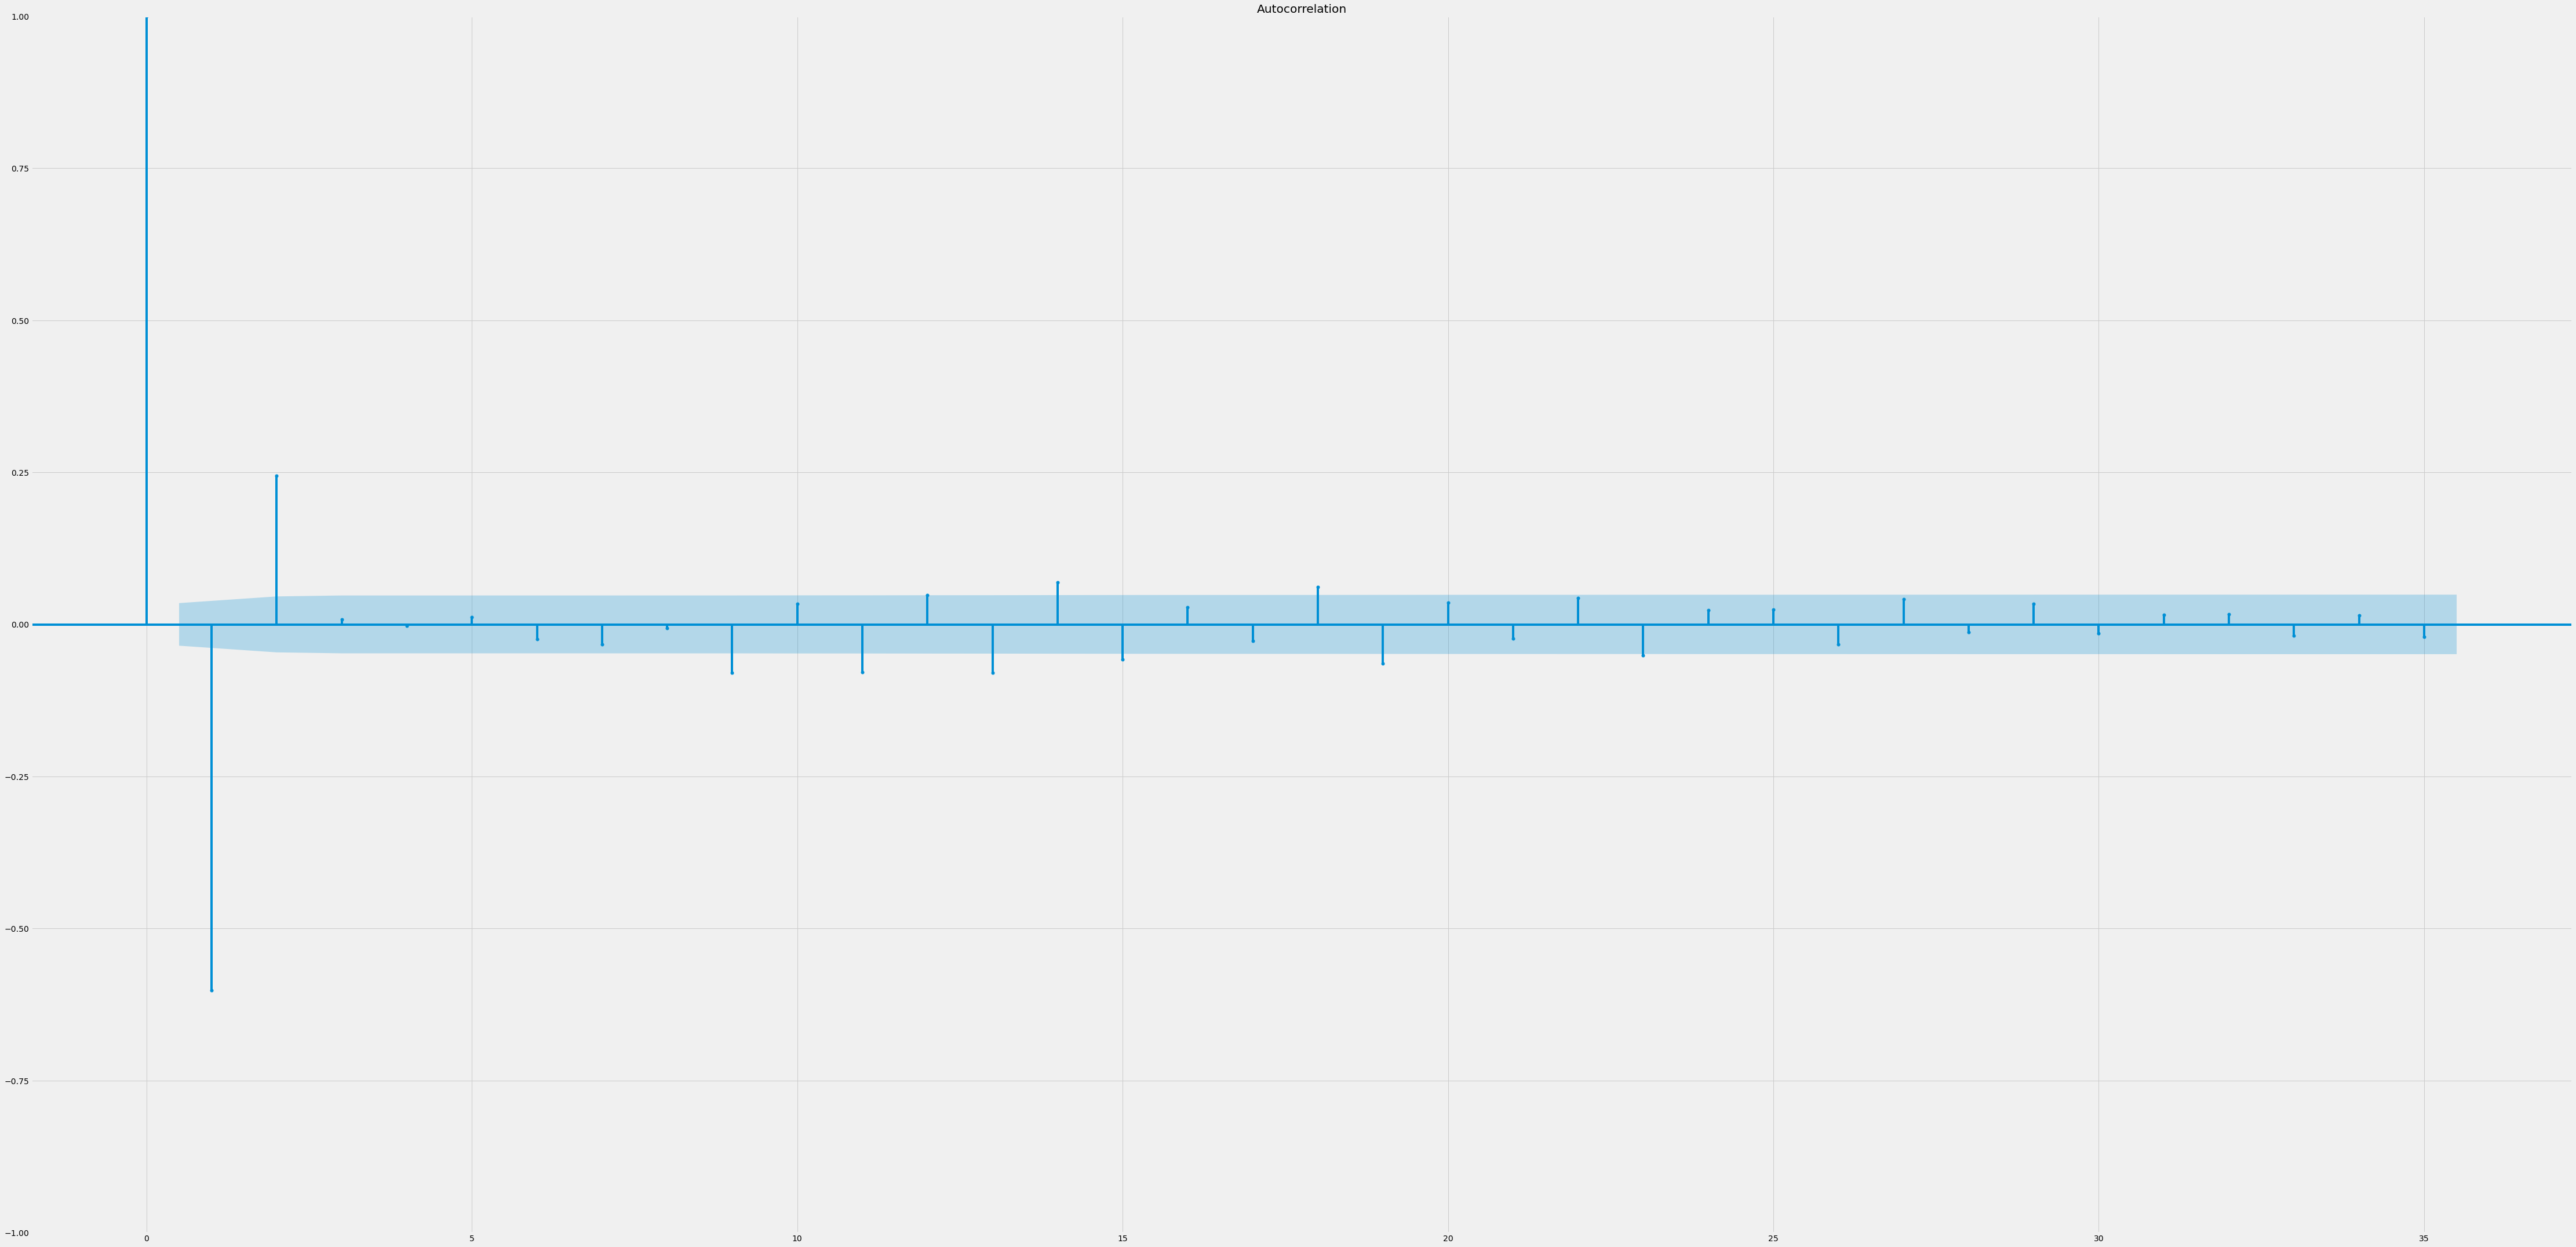

<Figure size 1500x500 with 0 Axes>

In [39]:
# Plot autocorrelations to determine parameter q

plot_acf(df_new)
plt.figure(figsize=(15,5), dpi=100)
plt.show()

#### will start with a q value of 3

### b Splitting data

In [40]:
dfn=df2.reset_index()

In [41]:
dfn

Date  delay_smooth
0    2014-01-01         336.0
1    2014-01-02         342.0
2    2014-01-03         346.0
3    2014-01-04         352.0
4    2014-01-05         352.0
...         ...           ...
3129 2022-07-27         217.0
3130 2022-07-28         214.0
3131 2022-07-29         213.0
3132 2022-07-30         209.0
3133 2022-07-31         204.0

[3134 rows x 2 columns]

In [42]:
dfn.loc[dfn['Date']>'2019-12-31']

Date  delay_smooth
2191 2020-01-01         110.0
2192 2020-01-02         110.0
2193 2020-01-03         112.0
2194 2020-01-04         113.0
2195 2020-01-05         115.0
...         ...           ...
3129 2022-07-27         217.0
3130 2022-07-28         214.0
3131 2022-07-29         213.0
3132 2022-07-30         209.0
3133 2022-07-31         204.0

[943 rows x 2 columns]

In [73]:
df.head()

delay_count  delay_smooth
Date                                 
2014-01-01        125.0         336.0
2014-01-02        463.0         342.0
2014-01-03        525.0         346.0
2014-01-04        225.0         352.0
2014-01-05         97.0         352.0

In [80]:
#splitting data pre-covid and post-covid, before 2020 and after 2020
train = df_new['delay_smooth'][:2189]
test = df_new['delay_smooth'][2188:]

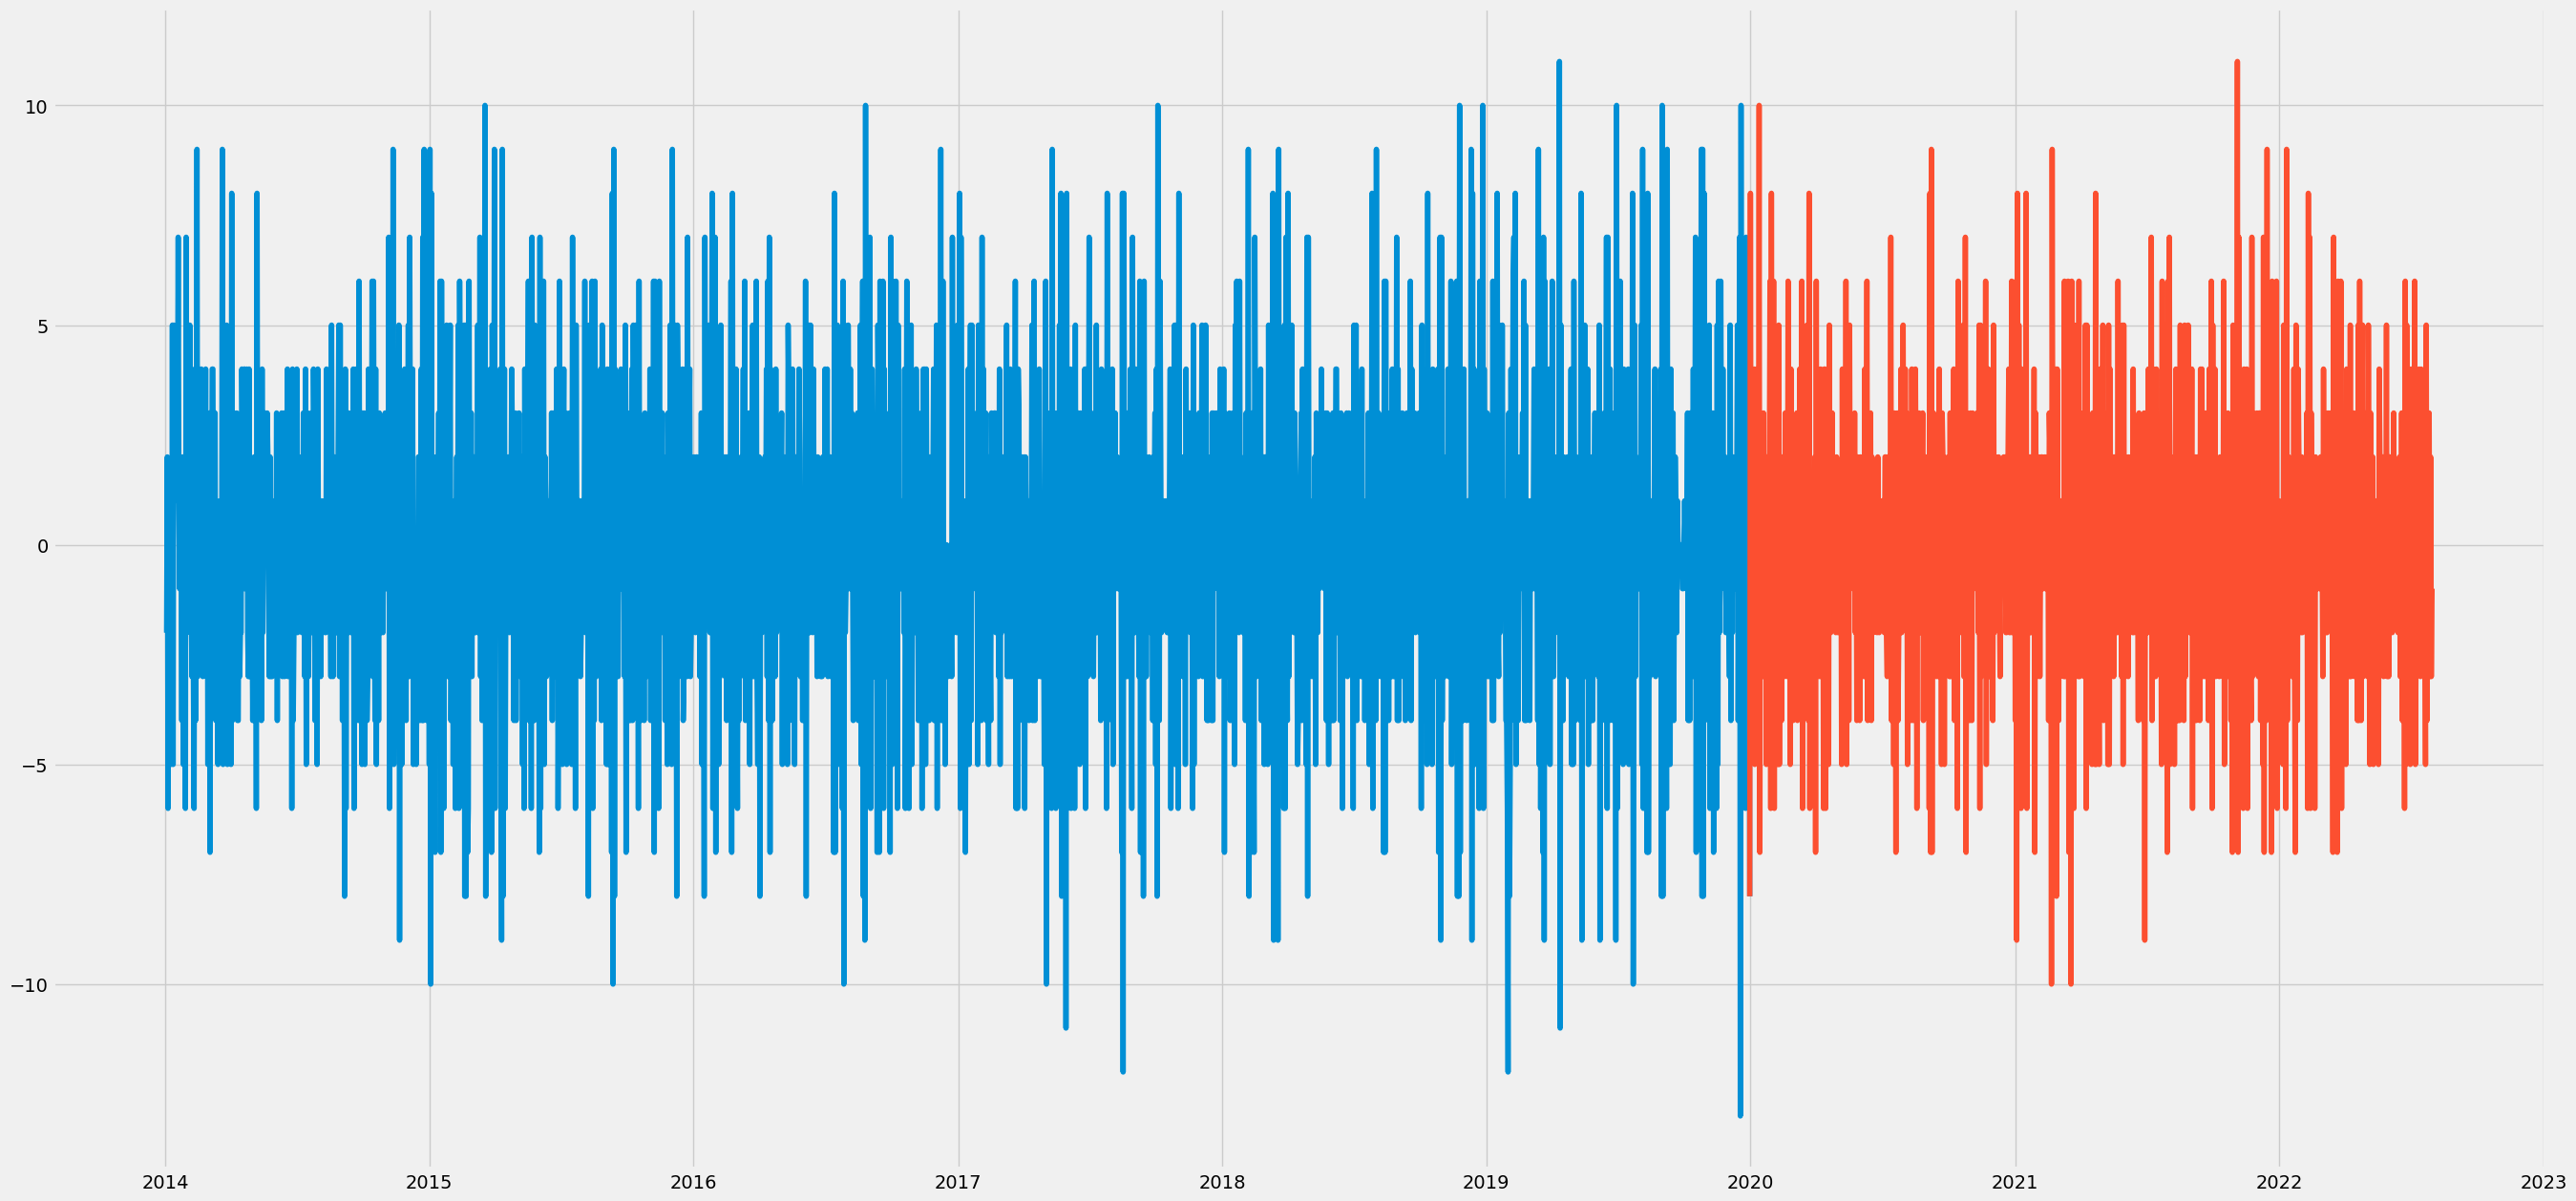

In [81]:
# Plot both sets in order to see the split

plt.figure(figsize=(30,15), dpi=100)
plt.plot(train)
plt.plot(test)

In [82]:
test.shape

(944,)

### c Running and Fitting the model

In [83]:
from statsmodels.tsa.api import ARIMA # Import the model you need

                               SARIMAX Results                                
Dep. Variable:           delay_smooth   No. Observations:                 2189
Model:                 ARIMA(1, 2, 3)   Log Likelihood               -5575.158
Date:                Mon, 19 Sep 2022   AIC                          11160.316
Time:                        17:56:21   BIC                          11188.768
Sample:                    01-03-2014   HQIC                         11170.716
                         - 12-31-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3614      0.028    -13.061      0.000      -0.416      -0.307
ma.L1         -2.1439      0.493     -4.349      0.000      -3.110      -1.178
ma.L2          1.6699      0.572      2.917      0.0

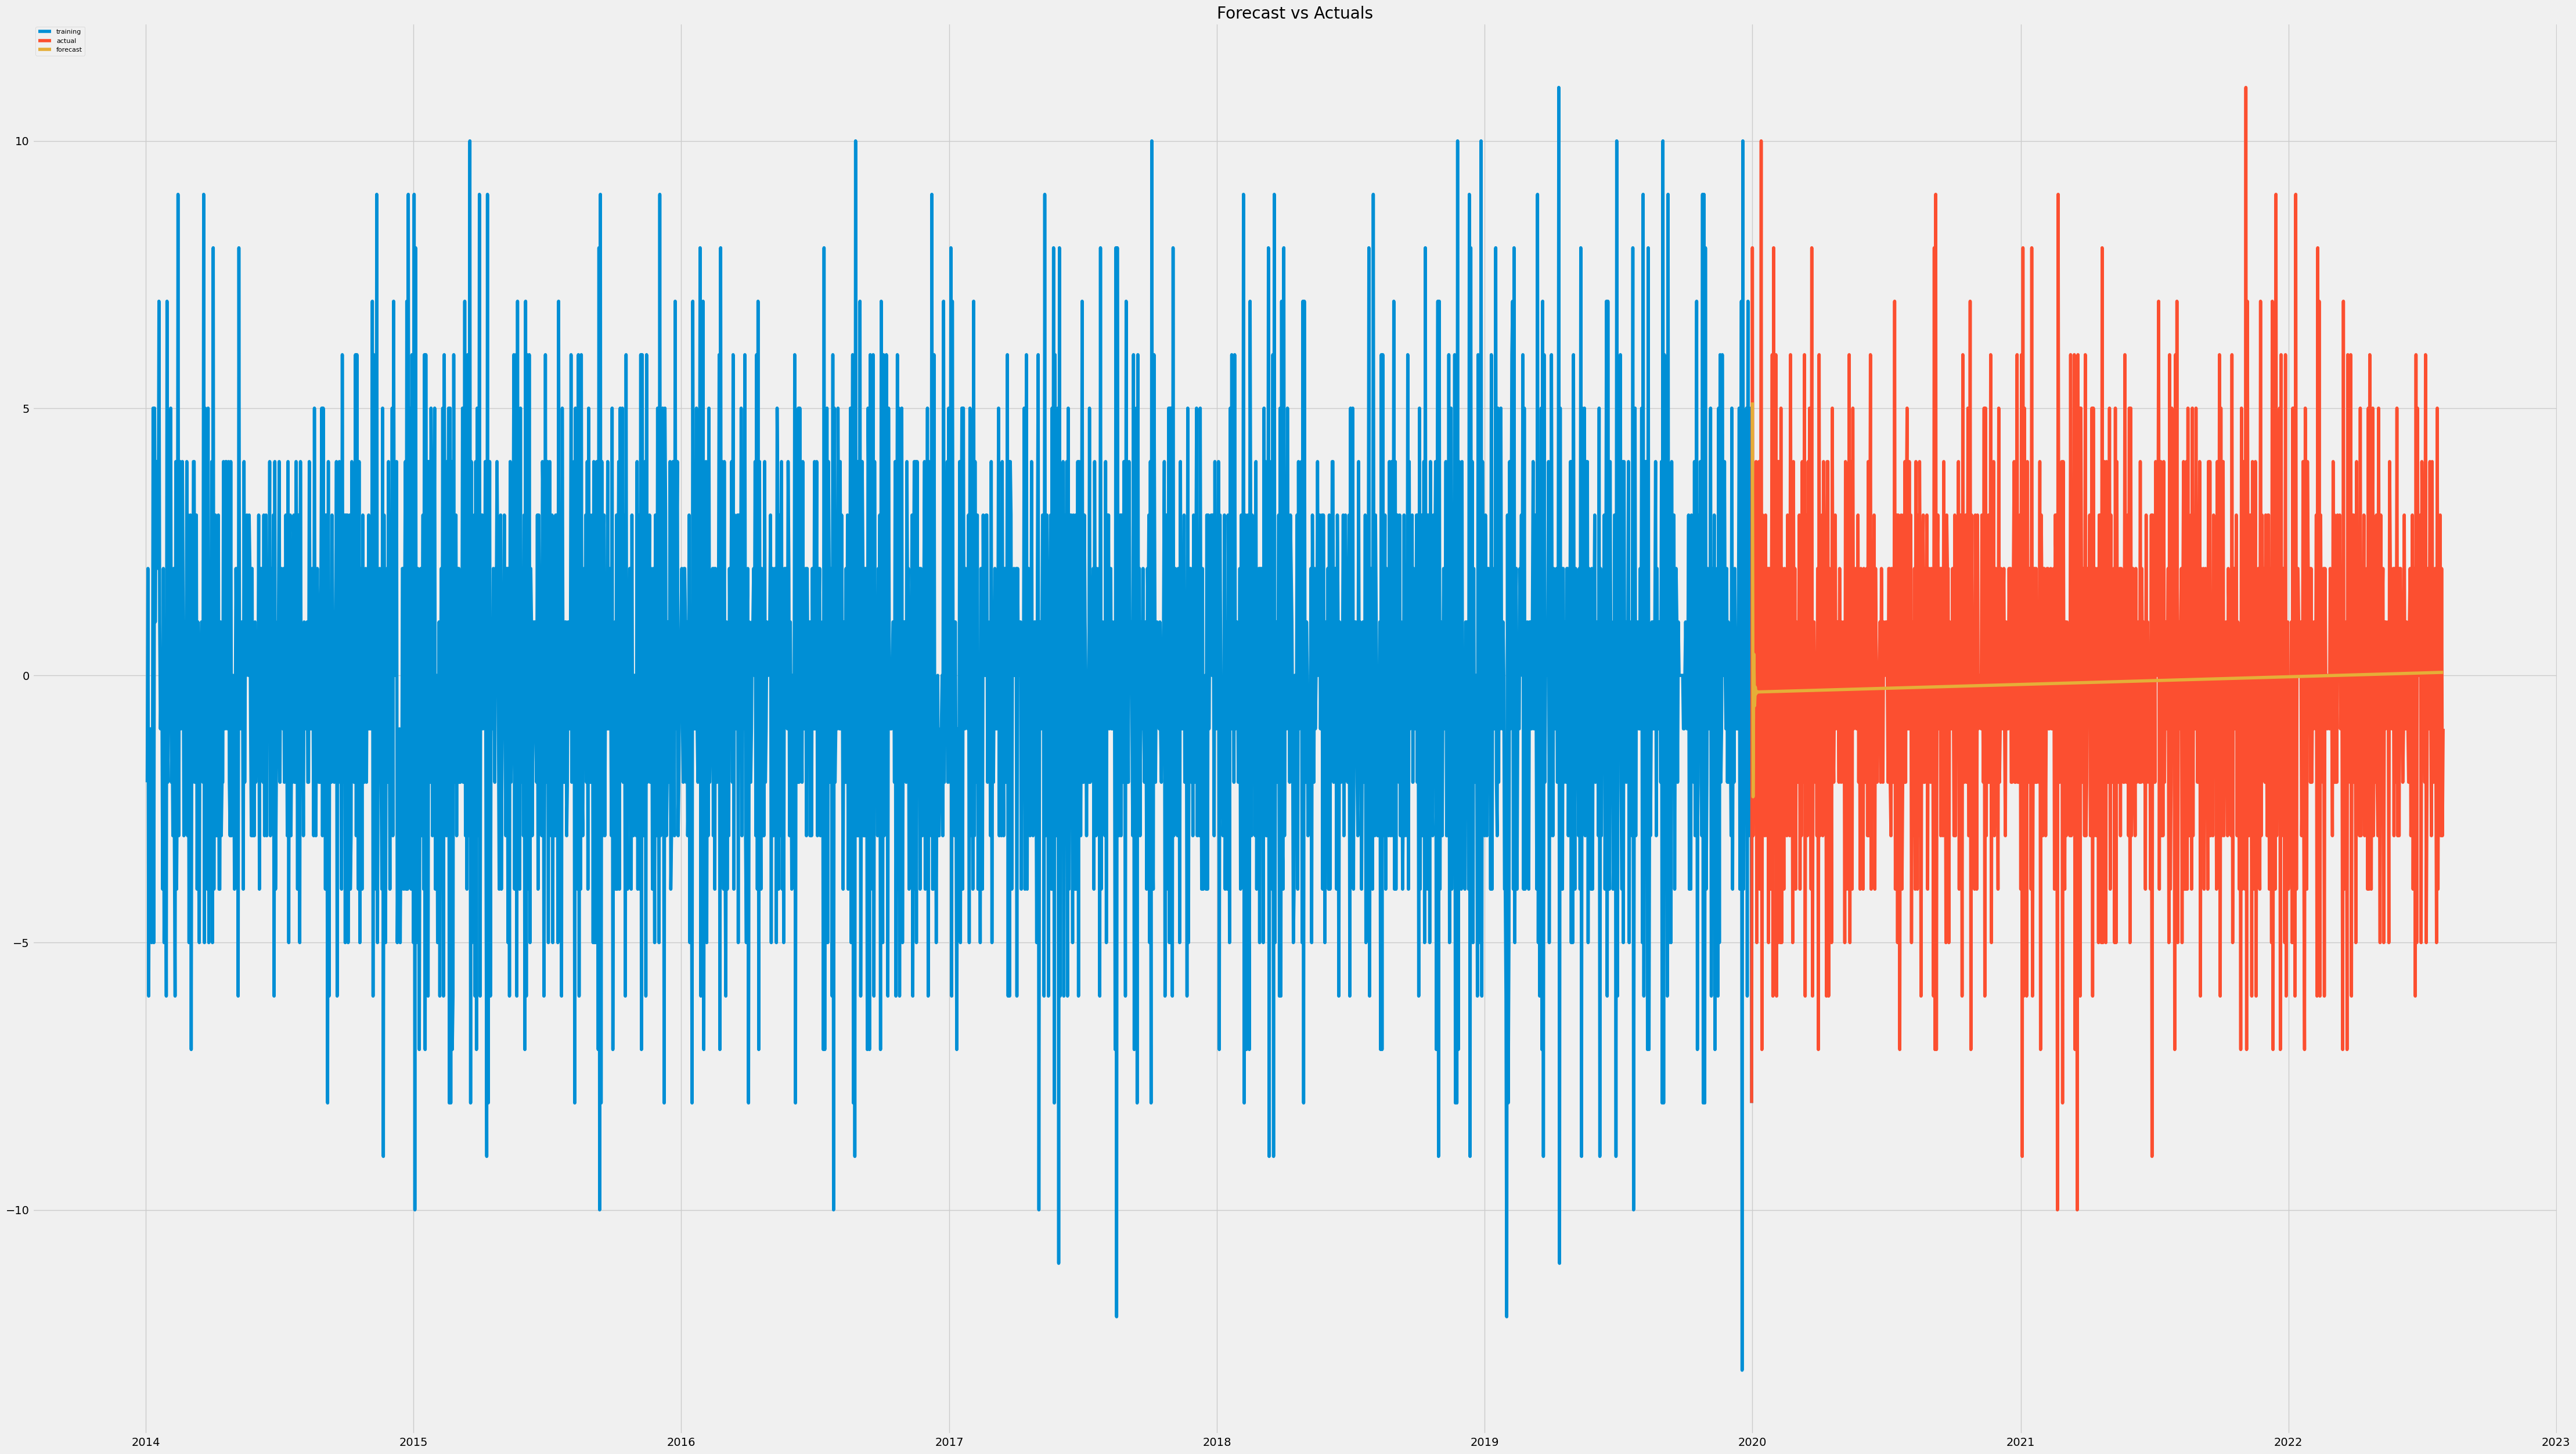

In [86]:
model = ARIMA(train, order=(1, 2, 3))  
fitted = model.fit()  
print(fitted.summary())

# Forecast
fc= fitted.forecast(946, alpha=0.05)  # 95% conf

# Make into pandas series
fc_series = pd.Series(fc, index=test.index)


# Plot
plt.figure(figsize=(50,30), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

#### all forecast coefficients are significant 

#### the forecast is satisfactory